## Introduction

In this notebook, we will run scopes with different hyperparameters for the three optimization datasets.

There are three primary objectives for this optimization and two secondary ones: The main objectives are to maximize the scope scores for all three datasets and find conditions that perform well for each of them. Additionally, minimizing the scope size and the number of rounds are secondary objectives.

In terms of the tunable hyperparameters, we can adjust the acquisition function, the scope and batch size, the amount of Vendi pruning, and when the Vendi pruning is applied (either before every batch or every sample). We will first screen different condition settings and then finetune the most promising ones.

In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..','..','..')))
from Code.benchmark import Benchmark
import seaborn as sns
import matplotlib.pyplot as plt
import re
import pandas as pd
import numpy as np
import warnings
from pathlib import Path
import os
import ast
import matplotlib as mpl
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import colorsys

# Doyle colors
doyle_colors = ["#CE4C6F", "#1561C2", "#188F9D","#C4ADA2","#515798", "#CB7D85", "#A9A9A9"]
# extension of palette with lighter and darker versions
def adjust_lightness(color, factor=1.2):
    """
    Function to make colors lighter (factor > 1) or darker (factor < 1).
    """
    r, g, b = mcolors.to_rgb(color)
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    l = max(0, min(1, l * factor))
    r, g, b = colorsys.hls_to_rgb(h, l, s)
    return mcolors.to_hex((r, g, b))

lighter = [adjust_lightness(c, 1.2) for c in doyle_colors]
darker  = [adjust_lightness(c, 0.7) for c in doyle_colors]
all_colors = doyle_colors + darker[::-1] + lighter[::-1] 

# Save the categorical colormap
cat_cmap = ListedColormap(all_colors, name="Doyle_cat")
plt.colormaps.register(cat_cmap)

# Define and save a continuous colormap
colors = [doyle_colors[1],"#FFFFFFD1",doyle_colors[0]]
cont_cmap = LinearSegmentedColormap.from_list("Doyle_cont", colors)
plt.colormaps.register(cont_cmap)

wdir = Path(".")

# General plt parameters
plt.rcParams.update({
    "axes.titlesize": 20,        # Subplot title
    "axes.labelsize": 16,        # X and Y labels
    "figure.titlesize": 24,      # Suptitle
    "xtick.labelsize": 14,       # X tick labels
    "ytick.labelsize": 14,       # Y tick labels
    "legend.fontsize": 14,       # Legend text
    "legend.title_fontsize": 14, # Legend titles
    "font.family": "Helvetica"   # Font
    })

Get the standardization metrics

In [2]:
# define a running variable with the datasets
datasets = ["high","medium","low"]
# define a variable with the acquisition functions
acqfct = ["balanced","greedy"]
# define some Vendi pruning options for the different batch sizes 
# (options were only selected if they would not exhaust any search space of the datasets)
batch_pruning_combinations = {2: [0,5,10,15,20,25], 3: [0,5,10,15,20,25,30,35], 4: [0,5,10,15,20,25,30,35,40,45]}

## Condition screening

In [3]:
# # run different settings with batch pruning (pruning before every round of experiments)
# for dset in datasets:
#     for acq in acqfct:
#         for batch in batch_pruning_combinations.keys():
#             Benchmark().collect_data(
#                 filename_labelled = f"./../0_Data/Datasets/Datasets_Hyperpar_Opt/data-{dset}.csv",  
#                 name_results = f"./Results_Data/Cond_Screen/screen_bprune/30{acq}_{dset}/30{acq}_b{batch}",  
#                 objectives=['rate'],  
#                 budget = 30,
#                 batches= [batch],
#                 Vendi_pruning_fractions = batch_pruning_combinations[batch],
#                 seeds = 20,
#                 acquisition_function_mode= acq,
#                 pruning_metric= "vendi_batch",
#                 init_sampling_method="random"
#                 )

In [4]:
# # run different settings with sample pruning (pruning before every sample)
# for dset in datasets:
#     for acq in acqfct:
#         Benchmark().collect_data(
#             filename_labelled = f"./../0_Data/Datasets/Datasets_Hyperpar_Opt/data-{dset}.csv",  
#             name_results = f"./Results_Data/Cond_Screen/screen_sprune/30{acq}_{dset}",  
#             objectives=['rate'],  
#             budget = 30,
#             batches= [2,3,4],
#             Vendi_pruning_fractions = [2,4,6,8,10,12],
#             seeds = 20,
#             acquisition_function_mode= acq,
#             pruning_metric= "vendi_sample",
#             init_sampling_method="random"
#             )

In [5]:
# load the normalization bounds
df_bounds = pd.read_csv(f"./../0_Data/Datasets/Datasets_Hyperpar_Opt/bounds.csv",index_col=0)
df_bounds

high    medium       low
obj_min    0.432225  1.174966  2.154690
obj_max    0.603510  1.984558  2.483439
vendi_min  2.392147  2.166708  2.043167
vendi_max  6.505295  6.313570  5.846067

In [6]:
# define a function to extract the relevant bounds in a format suitable for the Benchmark class
def get_bounds(dset):
    bounds = {}
    # get the metrics for the rate objective
    bounds["rate"] = (df_bounds.loc["obj_max",dset],df_bounds.loc["obj_min",dset])
    # get the metrics for the vendi score
    bounds["vendi"] = (df_bounds.loc["vendi_max",dset],df_bounds.loc["vendi_min",dset])

    return bounds

In [7]:
# combine the results for each dataset
dfs_results = {}
for dset in datasets:
    dfs = {}
    for prune in ["sprune","bprune"]:
        # read in the data
        for acq in acqfct:
            for batch in [2,3,4]:
                if prune == "sprune":
                    dfs_progress = Benchmark().progress_plot(budget=30, type_results="scope",
                                                            name_results=f"./Results_Data/Cond_Screen"\
                                                                f"/screen_{prune}/30{acq}_{dset}",
                                                            bounds=get_bounds(dset), show_plot = False)
                    dfs[f"{prune}_{acq}"] = dfs_progress["means"]
                elif prune == "bprune":
                    dfs_progress = Benchmark().progress_plot(budget=30, type_results="scope",
                                                            name_results=f"./Results_Data/Cond_Screen"\
                                                                f"/screen_{prune}/30{acq}_{dset}/30{acq}_b{batch}",
                                                            bounds=get_bounds(dset), show_plot = False)
                    dfs[f"{prune}_{acq}_b{batch}"] = dfs_progress["means"]
    # combine
    dfs_results[dset] = pd.concat(dfs,axis=1)
    # clean up the column names (currently multi index)
    dfs_results[dset].columns = [midx[0]+"_"+midx[1] for midx in dfs_results[dset].columns] 
    dfs_results[dset].columns = [re.sub(r'(b\d+)_b\d+', r'\1', col) 
                                 if "bprune" in col else col for col in dfs_results[dset].columns] 
    dfs_results[dset].columns = [re.sub(r'V(\d)(?!\d)', r'V0\1', col) for col in dfs_results[dset].columns]

    # sort the columns
    dfs_results[dset] = dfs_results[dset][sorted(dfs_results[dset].columns)]

    # cut off the data for batch size 2 at 20 samples to adhere to the maximum 10-rounds-of-reactions constraint
    dfs_results[dset].loc[dfs_results[dset].index > 20, dfs_results[dset].columns[dfs_results[dset].columns.str.contains("b2")]] = np.nan

There are 84 different scopes with 20 random seeds each for every dataset.
The shown results are averaged across the random seeds.


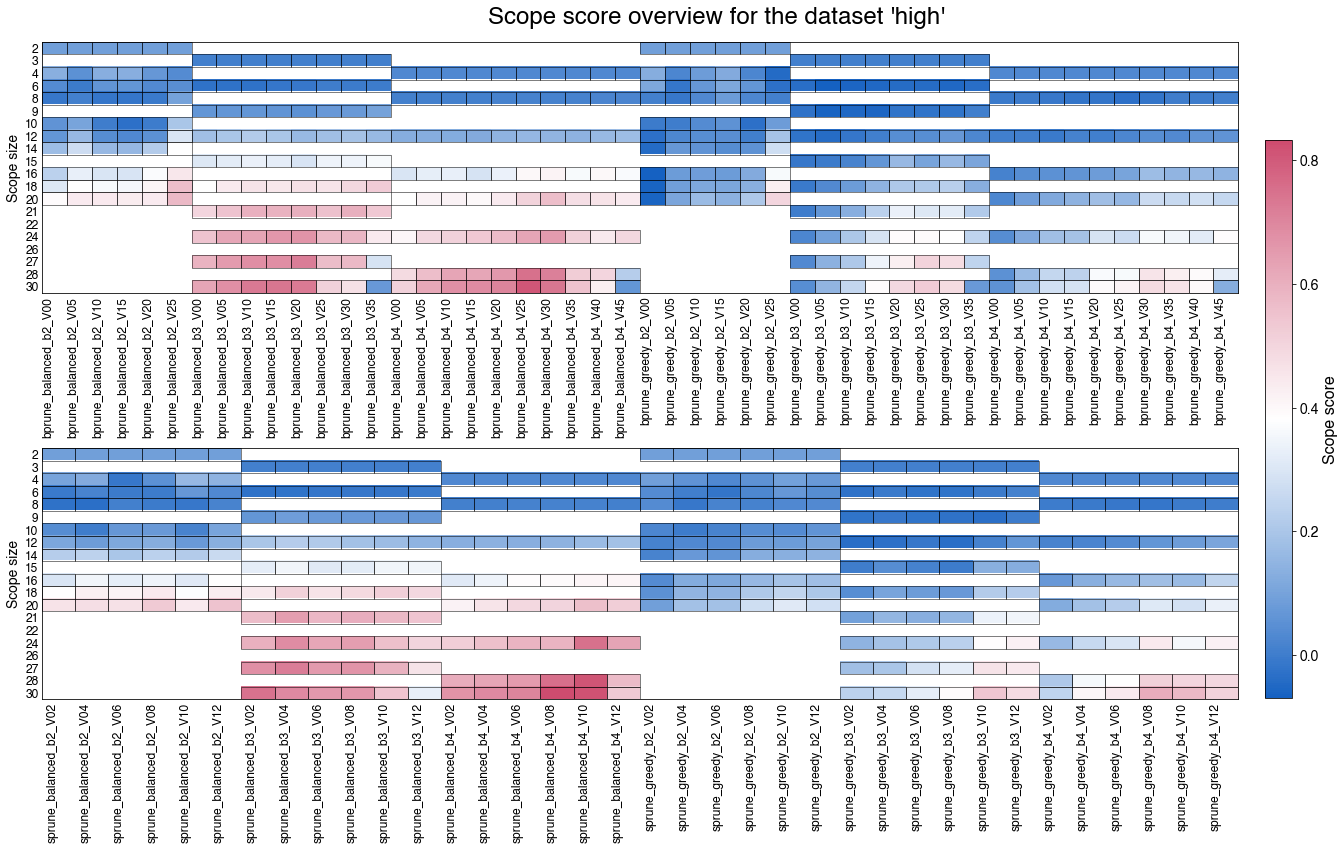

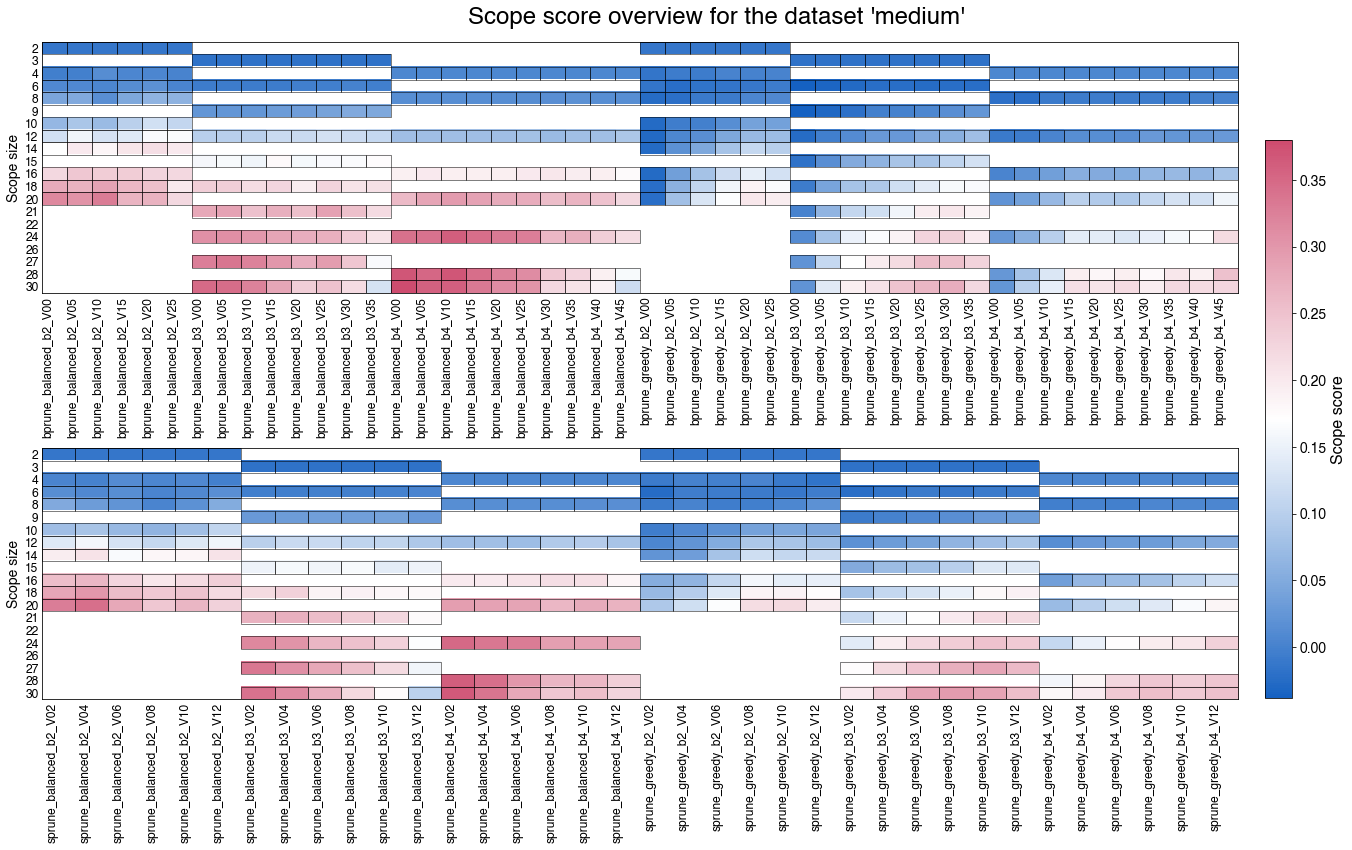

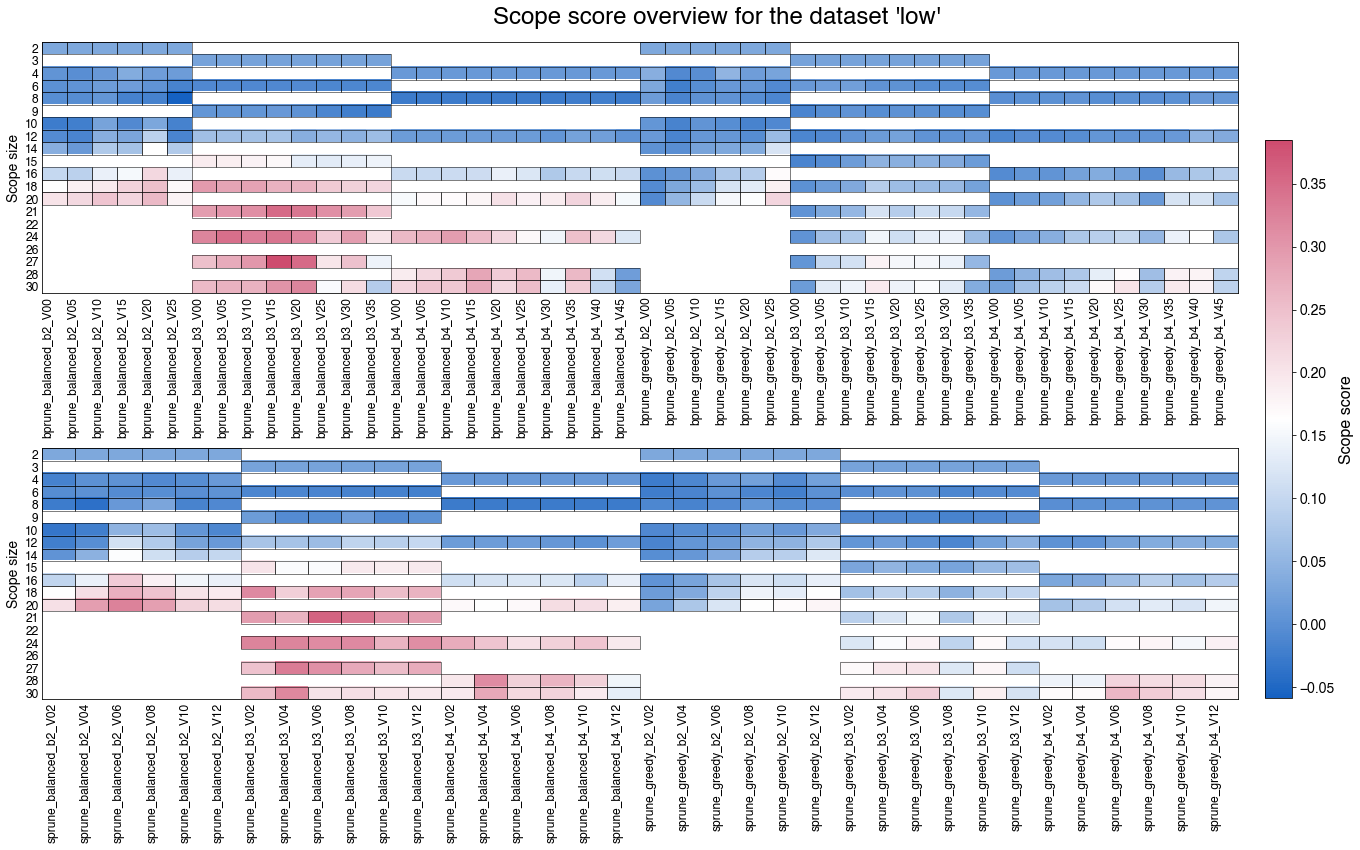

In [8]:
def get_overview_plot():
    warnings.filterwarnings("ignore", message=".*tight_layout.*")

    print(f"There are {len(dfs_results['high'].columns)} different scopes with "
          "20 random seeds each for every dataset.\nThe shown results are averaged across the random seeds.")

    for dset in datasets:
        fig, axes = plt.subplots(2, 1, figsize=(20, 12))
        fig.suptitle(f"Scope score overview for the dataset '{dset}'")

        # Select bprune and sprune data
        bprune_col = [col for col in dfs_results[dset].columns if "bprune" in col]
        sprune_col = [col for col in dfs_results[dset].columns if "sprune" in col]
        bprune_data = dfs_results[dset][bprune_col]
        sprune_data = dfs_results[dset][sprune_col]

        # Shared color scale
        min_val = dfs_results[dset].min().min()
        max_val = dfs_results[dset].max().max()

        # Define colormap with white for NaN
        cmap = plt.cm.get_cmap("Doyle_cont").copy()
        cmap.set_bad(color="white")

        # Helper to draw one heatmap
        def draw_heatmap(ax, data):
            arr = data.to_numpy()
            masked = np.ma.masked_invalid(arr)
            im = ax.imshow(masked, cmap=cmap, vmin=min_val, vmax=max_val, aspect="auto")

            # Draw grid lines only around non-NaN cells
            nrows, ncols = arr.shape
            for i in range(nrows):
                for j in range(ncols):
                    if not np.isnan(arr[i, j]):
                        ax.add_patch(plt.Rectangle(
                            (j - 0.5, i - 0.5), 1, 1,
                            fill=False, edgecolor="k", lw=0.5
                        ))

            # Axes labels & ticks
            ax.set_xticks(np.arange(ncols))
            ax.set_yticks(np.arange(nrows))
            ax.set_xticklabels(data.columns, rotation=90, ha='right', fontsize=12)
            ax.set_yticklabels(data.index, fontsize=12)
            ax.tick_params(length=0)

            return im

        # Plot both heatmaps
        im0 = draw_heatmap(axes[0], bprune_data)
        im1 = draw_heatmap(axes[1], sprune_data)

        # Colorbar shared
        cbar = fig.colorbar(im0, ax=axes, location="right",
                            fraction=0.025, pad=0.02, label="Scope score")

        # Axis labels
        axes[0].set_ylabel("Scope size", fontsize=14)
        axes[1].set_ylabel("Scope size", fontsize=14)

        plt.tight_layout(rect=[0, 0, 0.87, 0.99])
        plt.show()

get_overview_plot()

Get the best scope score for each dataset

Best scope score for the dataset 'high': 0.83 (size30_sprune_balanced_b4_V08)
Best scope score for the dataset 'medium': 0.38 (size30_bprune_balanced_b4_V00)
Best scope score for the dataset 'low': 0.38 (size27_bprune_balanced_b3_V15)


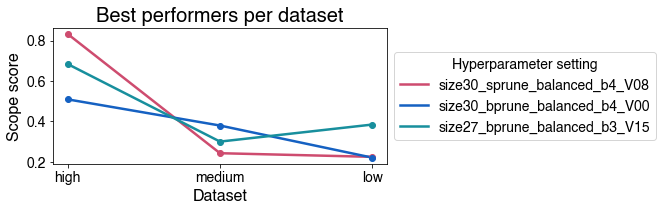

In [9]:
# get the highest scope score for each dataset

# stack the results into a single dataframe
def stacking():
    stacked_results =  pd.DataFrame({key:value.stack() for key,value in dfs_results.items()})
    stacked_results.index = [f"size{midx[0]}_"+midx[1] for midx in stacked_results.index]
    return stacked_results
stacked_results = stacking()
hyperpar_local_bests = []
for dset in datasets:
    # get the highest score
    max_score = stacked_results[dset].max()
    # get the position of this score
    hyperpar = stacked_results[stacked_results[dset] == max_score].index.to_list()[0]
    hyperpar_local_bests.append(str(hyperpar))
    print(f"Best scope score for the dataset '{dset}': {round(max_score,2)} ({hyperpar})")
# Plot the settings that gave the best results for one of the datasets
plt.figure(figsize=(6, 2.5))
# sns.lineplot(data=stacked_results.transpose()[hyperpar_local_bests], dashes=False, markers=True, markersize=8)
plotting_data = stacked_results.transpose()[hyperpar_local_bests]
for j,col in enumerate(plotting_data.columns):
    style = '-' if j <= 6 else '--' if j <= 13 else ':'
    plotting = plotting_data[col][plotting_data[col].notna()]
    plt.plot(plotting.index, plotting.values, label = col, color=all_colors[j], linestyle=style, linewidth=2.5,zorder=1)
    plt.scatter(plotting.index,plotting.values,zorder=2, color=all_colors[j])
plt.title('Best performers per dataset',fontsize=20)
plt.yscale("linear")
plt.xlabel("Dataset")
plt.ylabel("Scope score")
plt.legend(title='Hyperparameter setting', bbox_to_anchor=(1.02, 0.5), loc='center left', borderaxespad=0)
plt.show()


Get all the Pareto solutions

In [10]:
def pareto_front(df):
    """Get the Pareto front"""
    data = df.to_numpy()
    is_efficient = np.ones(data.shape[0], dtype=bool)
    
    for i, c in enumerate(data):
        if is_efficient[i]:
            # Keep only points that are NOT strictly worse than c
            is_efficient[is_efficient] = np.any(data[is_efficient] > c, axis=1) | np.all(data[is_efficient] == c, axis=1)
            is_efficient[i] = True
    return df[is_efficient].copy()

pareto_settings = pareto_front(stacked_results)
pareto_scaled = pareto_front(stacked_results)
# scale scope scores by normalizing them
for column in pareto_settings.columns:
    min_score = pareto_settings[column].min()
    max_score = pareto_settings[column].max()
    pareto_settings[f"{column} (norm.)"] = (pareto_settings[column] - 0)/(max_score-0)
    pareto_scaled[f"{column} (norm.)"] = (pareto_scaled[column] - min_score)/(max_score-min_score)

# Calculate the standard deviation of the scaled scope scores as a metric for the balance of the Pareto solutions
norm_cols = pareto_settings.columns[pareto_settings.columns.str.contains("norm")]
pareto_settings["Mean norm."] = pareto_settings[norm_cols].mean(axis=1)
pareto_settings["Std.Dev. norm."] = pareto_settings[norm_cols].std(axis=1)
pareto_settings.sort_values(by="Mean norm.",inplace=True,ascending=False)
pareto_scaled = pareto_scaled.reindex(pareto_settings.index)
print(f"There are {len(pareto_settings)} Paretos solutions.")

There are 29 Paretos solutions.


In [11]:
def plot_pareto(pareto_settings,pareto_scaled,rows_to_plot,preferred_solutions, all_colors=all_colors):

    # Plot the pareto solutions
    fig = plt.figure(figsize=(14, 10))
    gs = fig.add_gridspec(2, 2, width_ratios=[2, 2])
    fig.suptitle("Normalized scope scores of Pareto solutions for the different datasets",fontsize=20)
    line_handles = []
    line_labels = []

    # Parallel line plot
    ax1 = fig.add_subplot(gs[0, 0])
    # define a variable for the normalized columns
    norm_cols = ["high (norm.)","medium (norm.)","low (norm.)"]
    for i, (idx, row) in enumerate(pareto_scaled.iterrows()):
        if i == len(all_colors):
            all_colors = all_colors * 2  # make sure that the colors don't run out
        if i in rows_to_plot:
            handle, = ax1.plot(
                norm_cols,
                row[norm_cols],
                marker="o",
                markersize=4,
                color=all_colors[i],
                linewidth=2,
                label=idx)
            line_handles.append(handle)
            line_labels.append(f"{idx}")
    ax1.tick_params(axis='x', labelsize=14) 
    ax1.set_ylim(-0.05, 1.05)
    ax1.set_yscale("linear")
    ax1.set_ylabel("Normalized scope score\n(norm. with min. value = lowest Pareto setting)",fontsize=14)

    # 3D plot
    ax2 = fig.add_subplot(gs[0, 1], projection='3d')

    # plot points
    for i, (_, row) in enumerate(pareto_scaled.iterrows()):
        if i in rows_to_plot and i in preferred_solutions:
            ax2.scatter(row['high (norm.)'], row['medium (norm.)'], row['low (norm.)'], s=80, 
                        color=all_colors[i],edgecolor="k",linewidth=0.5)
        elif i in rows_to_plot:  # smaller points for the less balanced solutions
            ax2.scatter(row['high (norm.)'], row['medium (norm.)'], row['low (norm.)'], s=30, color=all_colors[i])
    
    ax2.set_xlim(-0.05,1.05)
    ax2.set_ylim(-0.05,1.05)
    ax2.set_zlim(-0.05,1.05)

    # add support lines to each plane
    for i, (_, row) in enumerate(pareto_scaled.iterrows()):
        x, y, z = row['high (norm.)'], row['medium (norm.)'], row['low (norm.)']
        col = all_colors[i]
        # ax2.plot([0, x], [y, y], [z, z], color=col, alpha=0.35, linestyle='-', linewidth=2.5)
        # ax2.plot([x, x], [0, y], [z, z], color=col, alpha=0.35, linestyle='-', linewidth=2.5)
        if i in rows_to_plot and i in preferred_solutions:
            ax2.plot([x, x], [y, y], [0, z], color=col, alpha=0.6, linestyle='-', linewidth=3.5)
        elif i in rows_to_plot:
            ax2.plot([x, x], [y, y], [0, z], color=col, alpha=0.35, linestyle='-', linewidth=2)

    ax2.set_xlabel('high',fontsize=14)
    ax2.set_ylabel('medium',fontsize=14)
    ax2.set_zlabel('low',fontsize=14)
    ax2.set_title("Normalized scope score\n(norm. with min. value = lowest Pareto setting)",fontsize=14)


    # Plot mean and standard deviation
    ax3 = fig.add_subplot(gs[1, 0])
    for i, (_, row) in enumerate(pareto_settings.iterrows()):
        if i in rows_to_plot and i in preferred_solutions:
            ax3.scatter(row["Std.Dev. norm."],row["Mean norm."],color=all_colors[i],
                s=80, edgecolor="k",linewidth=0.5)
        elif i in rows_to_plot:  # smaller points for the less balanced solutions
            ax3.scatter(row["Std.Dev. norm."],row["Mean norm."],color=all_colors[i], s=30)
    ax3.set_xlim(pareto_settings["Std.Dev. norm."].min()-0.05,pareto_settings["Std.Dev. norm."].max()+0.05)
    ax3.set_ylim(pareto_settings["Mean norm."].min()-0.05,pareto_settings["Mean norm."].max()+0.05)
    ax3.set_xlabel("Std.Dev. of normalized scope scores",fontsize=16)
    ax3.set_ylabel("Mean of normalized scope scores\n(norm. with min. value = 0)",fontsize=14)

    ax4 = fig.add_subplot(gs[1, 1])
    ax4.axis('off')
    ax4.legend(
        line_handles, line_labels,
        title="Pareto Solutions",
        loc="center",
        handleheight=2,
        labelspacing=1.2,
        ncol=2,
        fontsize=12
    )

    plt.tight_layout()
    plt.show()

def get_pareto_table(preferred_solutions,additionally_considered_solutions,preference_column):
    # color names for the plot labels
    color_names = ["red","blue","green","ocher","purple","red brown", "grey", "dark grey", "brown", 
                   "dark pruple", "dark ocher", "dark green", "dark blue", "dark red", "light grey", 
                   "salmon", "light purple", "light brown", "light green", "light blue", "light red"]*5
    
    # make a copy to display the rounded results for better visibility
    df_display_results = pareto_settings.copy(deep=True)
    df_display_results = df_display_results.applymap(lambda x : round(x,2))
    for i,(idx,row) in enumerate(df_display_results.iterrows()):
        df_display_results.loc[idx,"Plot color"] = color_names[i]
        df_display_results.loc[idx,preference_column] = "No"
        if i in preferred_solutions:
            df_display_results.loc[idx,preference_column] = "Yes"
        if i in additionally_considered_solutions:
            df_display_results.loc[idx,preference_column] = "Yes, but less preferred"
    return df_display_results

Visualization of the top 20 Pareto solutions by mean normalized scope score.


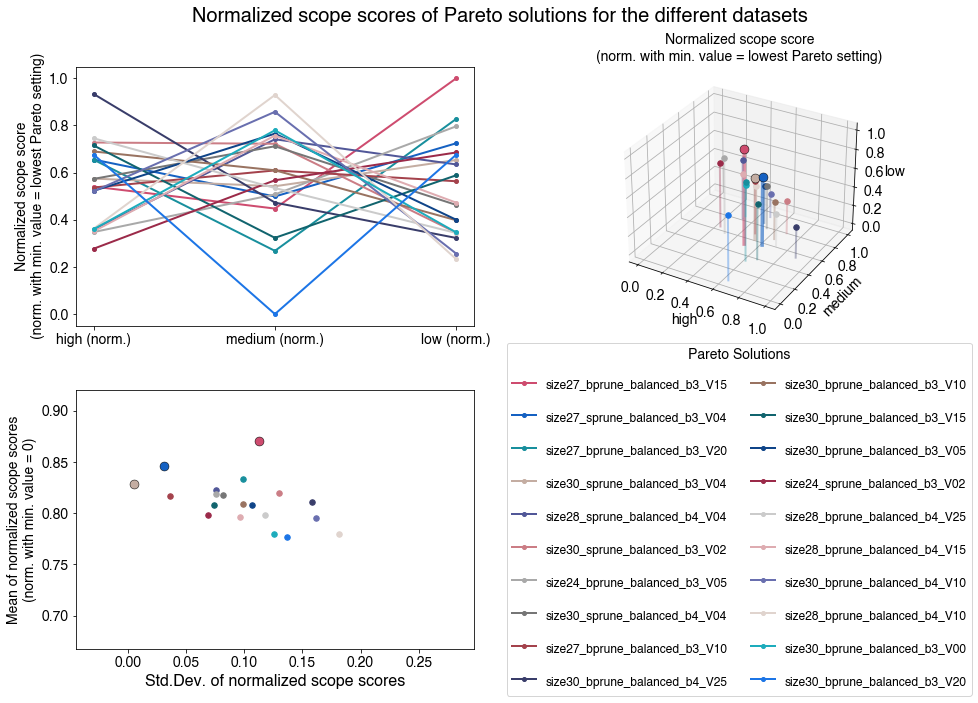

high  medium   low  high (norm.)  \
size27_bprune_balanced_b3_V15  0.68    0.30  0.38          0.82   
size27_sprune_balanced_b3_V04  0.72    0.31  0.33          0.87   
size27_bprune_balanced_b3_V20  0.72    0.27  0.35          0.87   
size30_sprune_balanced_b3_V04  0.69    0.31  0.32          0.83   
size28_sprune_balanced_b4_V04  0.62    0.34  0.31          0.75   
size30_sprune_balanced_b3_V02  0.74    0.34  0.26          0.89   
size24_bprune_balanced_b3_V05  0.62    0.31  0.34          0.75   
size30_sprune_balanced_b4_V04  0.69    0.34  0.28          0.83   
size27_bprune_balanced_b3_V10  0.68    0.32  0.30          0.82   
size30_bprune_balanced_b4_V25  0.81    0.30  0.25          0.97   
size30_bprune_balanced_b3_V10  0.73    0.32  0.27          0.88   
size30_bprune_balanced_b3_V15  0.74    0.28  0.30          0.89   
size30_bprune_balanced_b3_V05  0.68    0.35  0.27          0.81   
size24_sprune_balanced_b3_V02  0.60    0.32  0.32          0.72   
size28_bprune_balanced_b4_V25  0.75    0.31  0.26          0.90   
size28_bprune_balanced_b4_V15  0.62    0.34  0.28          0.75   
size30_bprune_balanced_b4_V10  0.68    0.36  0.24          0.81   
size28_bprune_balanced_b4_V10  0.63    0.37  0.24          0.75   
size30_bprune_balanced_b3_V00  0.63    0.35  0.26          0.75   
size30_bprune_balanced_b3_V20  0.73    0.24  0.32          0.87   
size24_bprune_balanced_b4_V10  0.51    0.36  0.29          0.61   
size30_bprune_balanced_b4_V05  0.62    0.36  0.24          0.74   
size28_sprune_balanced_b4_V08  0.75    0.26  0.26          0.90   
size30_sprune_balanced_b4_V02  0.67    0.37  0.19          0.81   
size24_sprune_balanced_b4_V02  0.52    0.35  0.27          0.62   
size28_sprune_balanced_b4_V10  0.81    0.26  0.23          0.98   
size30_sprune_balanced_b4_V08  0.83    0.24  0.22          1.00   
size30_bprune_balanced_b4_V00  0.51    0.38  0.22          0.61   
size30_sprune_balanced_b4_V10  0.82    0.26  0.19          0.98   

                               medium (norm.)  low (norm.)  Mean norm.  \
size27_bprune_balanced_b3_V15            0.79         1.00        0.87   
size27_sprune_balanced_b3_V04            0.81         0.86        0.85   
size27_bprune_balanced_b3_V20            0.72         0.91        0.83   
size30_sprune_balanced_b3_V04            0.83         0.83        0.83   
size28_sprune_balanced_b4_V04            0.90         0.82        0.82   
size30_sprune_balanced_b3_V02            0.89         0.67        0.82   
size24_bprune_balanced_b3_V05            0.81         0.90        0.82   
size30_sprune_balanced_b4_V04            0.89         0.73        0.82   
size27_bprune_balanced_b3_V10            0.85         0.78        0.82   
size30_bprune_balanced_b4_V25            0.80         0.66        0.81   
size30_bprune_balanced_b3_V10            0.85         0.70        0.81   
size30_bprune_balanced_b3_V15            0.74         0.79        0.81   
size30_bprune_balanced_b3_V05            0.91         0.70        0.81   
size24_sprune_balanced_b3_V02            0.84         0.84        0.80   
size28_bprune_balanced_b4_V25            0.82         0.67        0.80   
size28_bprune_balanced_b4_V15            0.91         0.73        0.80   
size30_bprune_balanced_b4_V10            0.95         0.62        0.79   
size28_bprune_balanced_b4_V10            0.97         0.61        0.78   
size30_bprune_balanced_b3_V00            0.92         0.67        0.78   
size30_bprune_balanced_b3_V20            0.62         0.84        0.78   
size24_bprune_balanced_b4_V10            0.95         0.76        0.78   
size30_bprune_balanced_b4_V05            0.94         0.63        0.77   
size28_sprune_balanced_b4_V08            0.69         0.69        0.76   
size30_sprune_balanced_b4_V02            0.96         0.50        0.76   
size24_sprune_balanced_b4_V02            0.92         0.72        0.75   
size28_sprune_balanced_b4_V10            0.69         0.59        0.75   
size30_sprune_balanced

In [12]:
preferred_solutions = [0,1,3]
additionally_considered_solutions = [2,4,5,6,7,8,9,10,11,12,13,15]
print("Visualization of the top 20 Pareto solutions by mean normalized scope score.")
plot_pareto(pareto_settings,pareto_scaled,list(range(20)),preferred_solutions)
df_display_results = get_pareto_table(preferred_solutions,additionally_considered_solutions,"Further considered")
df_display_results

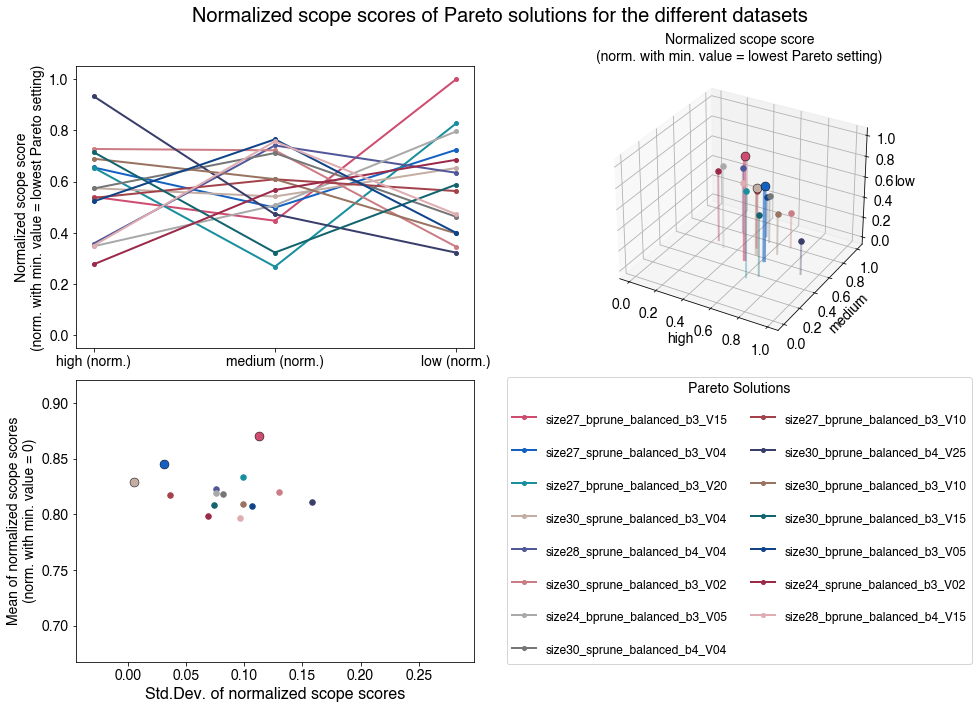

In [13]:
plot_pareto(pareto_settings,pareto_scaled,preferred_solutions+additionally_considered_solutions,preferred_solutions)

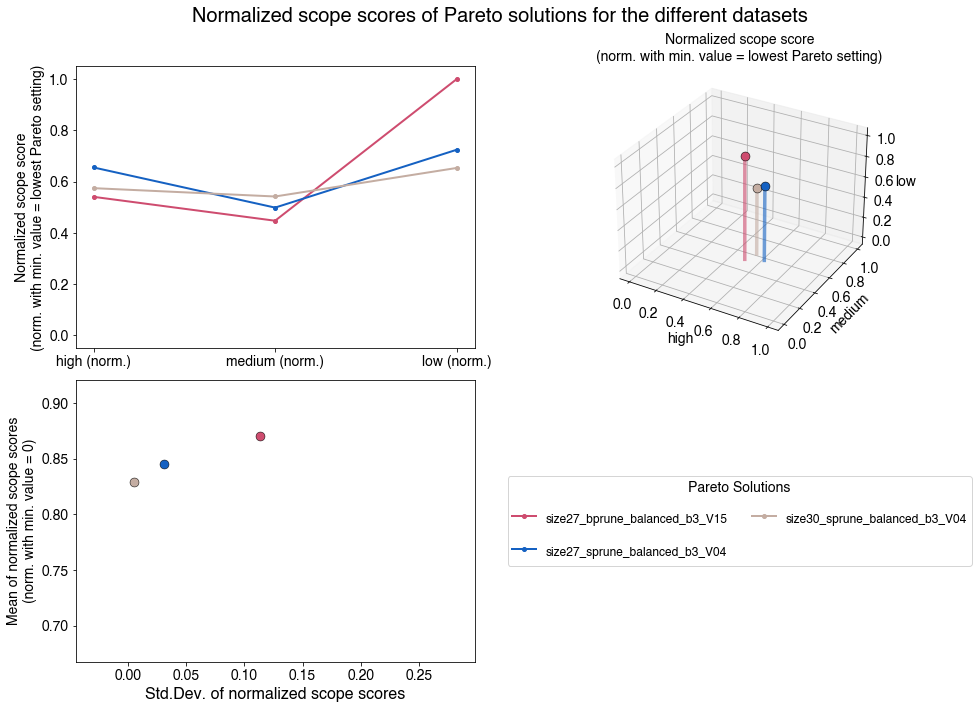

In [14]:
plot_pareto(pareto_settings,pareto_scaled,preferred_solutions,preferred_solutions)

## Finetuning the best performing settings

In [15]:
# # run different settings with batch pruning (pruning before every round of experiments)
# acq = "balanced"
# for dset in datasets:
#     batch_pruning_combinations = {3: [1,2,3,4,6,7,8,9,11,12,13,14,16,17,18,19,21,22,23,24]}
#     for batch in batch_pruning_combinations:
#         Benchmark().collect_data(
#             filename_labelled = f"./../0_Data/Datasets/Datasets_Hyperpar_Opt/data-{dset}.csv",  
#             name_results = f"./Results_Data/Cond_Screen/screen_bprune/tuning/30{acq}_{dset}/30{acq}_b{batch}",  
#             objectives=['rate'],  
#             budget = 30,
#             batches= [batch],
#             Vendi_pruning_fractions = batch_pruning_combinations[batch],
#             seeds = 20,
#             acquisition_function_mode= acq,
#             pruning_metric= "vendi_batch",
#             init_sampling_method="random"
#             )

In [16]:
# # run different settings with batch pruning (pruning before every round of experiments)
# acq = "balanced"
# for dset in datasets:
#     batch_pruning_combinations = {4: [11,12,13,14,16,17,18,19,21,22,23,24,26,27,28,29]}
#     for batch in batch_pruning_combinations:
#         Benchmark().collect_data(
#             filename_labelled = f"./../0_Data/Datasets/Datasets_Hyperpar_Opt/data-{dset}.csv",  
#             name_results = f"./Results_Data/Cond_Screen/screen_bprune/tuning/30{acq}_{dset}/30{acq}_b{batch}",  
#             objectives=['rate'],  
#             budget = 30,
#             batches= [batch],
#             Vendi_pruning_fractions = batch_pruning_combinations[batch],
#             seeds = 20,
#             acquisition_function_mode= acq,
#             pruning_metric= "vendi_batch",
#             init_sampling_method="random"
#             )

In [17]:
# # run different settings with sample pruning (pruning before every sample)
# for dset in datasets:
#     batch_pruning_combinations = {3: [1,3,5], 4: [3,5]}
#     for batch in batch_pruning_combinations:
#         Benchmark().collect_data(
#             filename_labelled = f"./../0_Data/Datasets/Datasets_Hyperpar_Opt/data-{dset}.csv",  
#             name_results = f"./Results_Data/Cond_Screen/screen_sprune/tuning/30balanced_{dset}/30balanced_b{batch}",  
#             objectives=['rate'],  
#             budget = 30,
#             batches= [batch],
#             Vendi_pruning_fractions = batch_pruning_combinations[batch],
#             seeds = 20,
#             acquisition_function_mode= "balanced",
#             pruning_metric= "vendi_sample",
#             init_sampling_method="random"
#             )

In [18]:
# extract the data from the finetuning runs
dfs_results_ftuning = {}
for dset in datasets:
    dfs = {}
    for prune in ["sprune","bprune"]:
        # read in the data
        for acq in acqfct:
            for batch in [3,4]:
                if prune == "sprune":
                    if acq == "balanced":  # restrict to settings that exist
                        dfs_progress = Benchmark().progress_plot(budget=30,type_results="scope",
                                                                name_results=f"./Results_Data/Cond_Screen/screen_{prune}/tuning/30{acq}_{dset}/30{acq}_b{batch}",
                                                                bounds=get_bounds(dset),show_plot = False)
                        dfs[f"{prune}_{acq}_b{batch}"] = dfs_progress["means"]
                elif prune == "bprune":
                    if acq == "balanced":
                        dfs_progress = Benchmark().progress_plot(budget=30,type_results="scope",
                                                                name_results=f"./Results_Data/Cond_Screen/screen_{prune}/tuning/30{acq}_{dset}/30{acq}_b{batch}",
                                                                bounds=get_bounds(dset),show_plot = False)
                        dfs[f"{prune}_{acq}_b{batch}"] = dfs_progress["means"]
    # combine
    dfs_results_ftuning[dset] = pd.concat(dfs,axis=1)
    # clean up the column names (currently multi index)
    dfs_results_ftuning[dset].columns = [midx[0]+"_"+midx[1].split("_")[1] for midx in dfs_results_ftuning[dset].columns] 
    dfs_results_ftuning[dset].columns = [re.sub(r'(b\d+)_b\d+', r'\1', col) 
                                         if "bprune" in col else col 
                                         for col in dfs_results_ftuning[dset].columns] 
    dfs_results_ftuning[dset].columns = [re.sub(r'V(\d)(?!\d)', r'V0\1', col) for col in dfs_results_ftuning[dset].columns]

    # sort the columns
    dfs_results_ftuning[dset] = dfs_results_ftuning[dset][sorted(dfs_results_ftuning[dset].columns)]

    # cut off the data for batch size 2 at 20 samples to adhere to the maximum 10-rounds-of-reactions constraint
    dfs_results_ftuning[dset].loc[dfs_results_ftuning[dset].index > 20, 
                                  dfs_results_ftuning[dset].columns[dfs_results_ftuning[dset].columns.str.contains("b2")]] = np.nan

There are 125 different scopes with 20 random seeds each for every dataset.
The shown results are averaged across the random seeds.


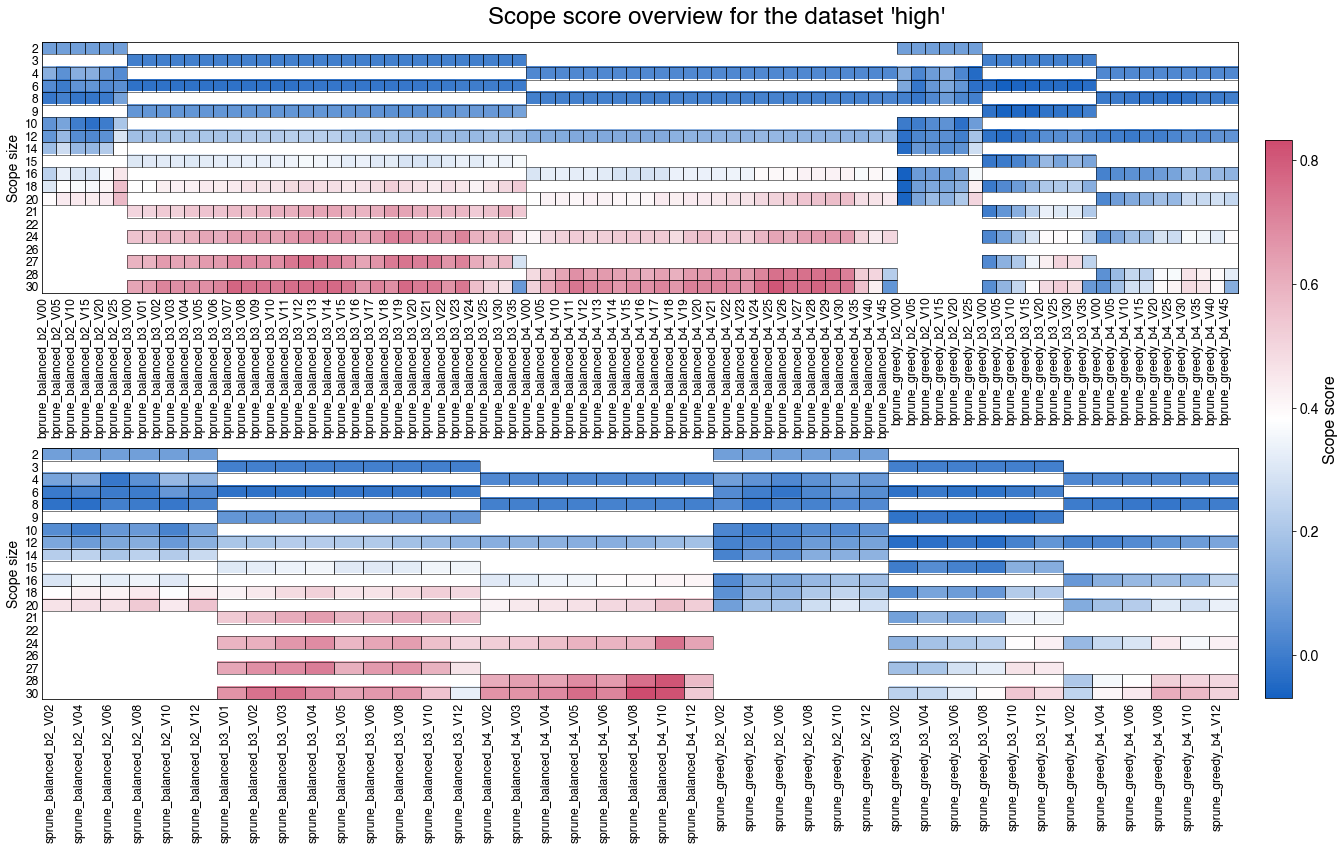

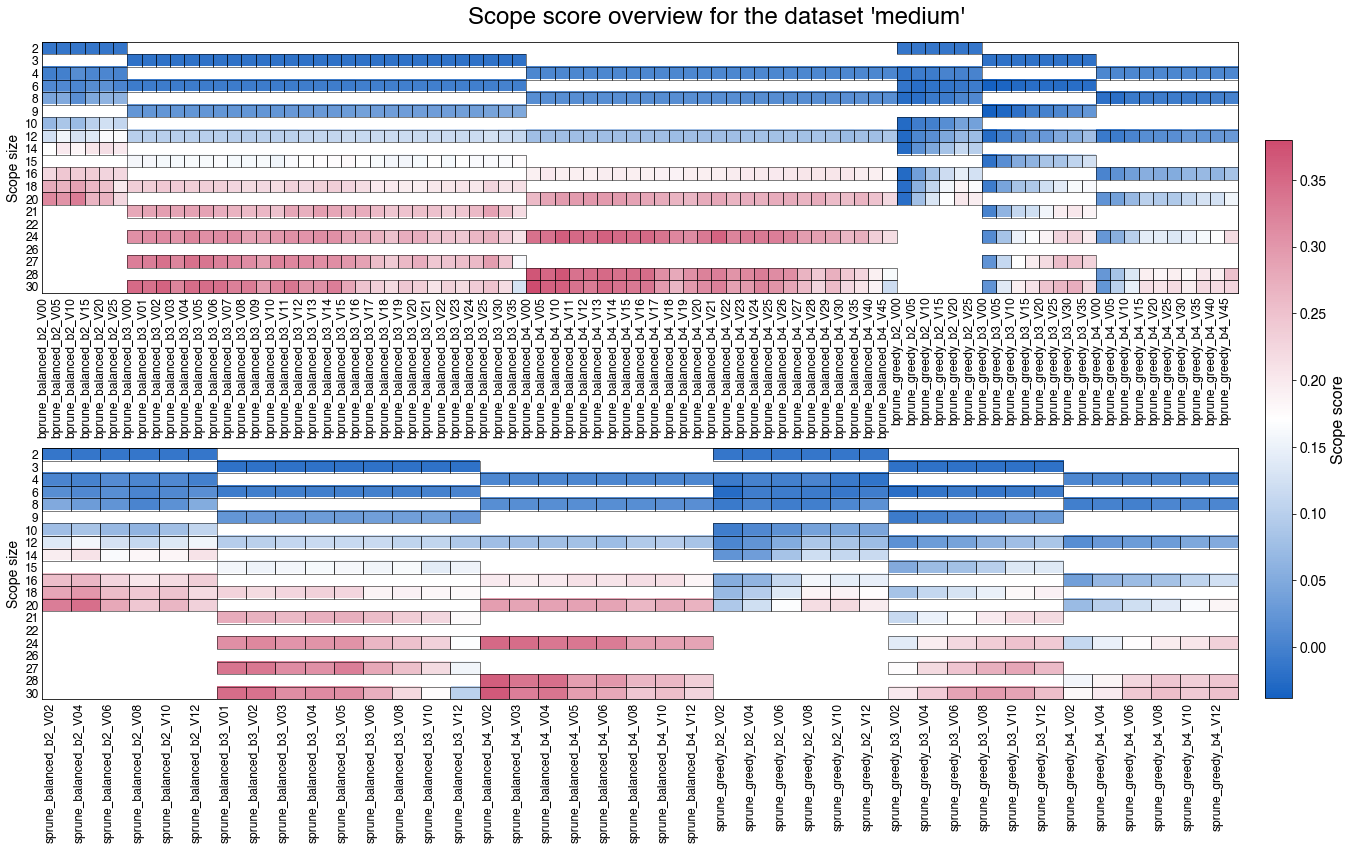

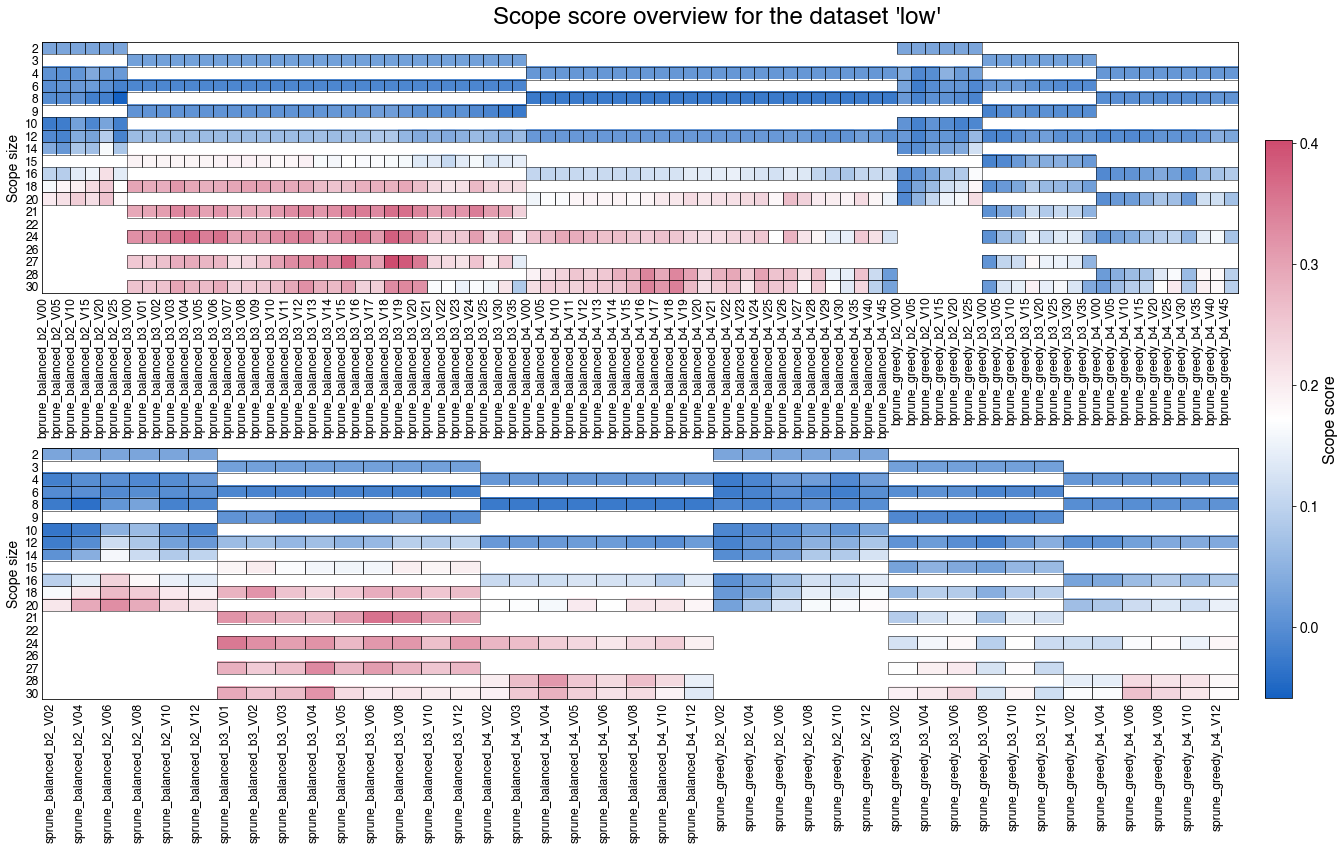

In [19]:
# combine with the already existing results
for dset in datasets:
    # combine
    dfs_results[dset] = pd.concat([dfs_results[dset],dfs_results_ftuning[dset]],axis=1)
    # sort the columns
    dfs_results[dset] = dfs_results[dset][sorted(dfs_results[dset].columns)]   

# plot the overview for all the results
get_overview_plot() 

In [20]:
stacked_results = stacking()
highest_scores = []
for dset in datasets:
    max_val = stacked_results[dset].max()
    highest_scores.append(max_val)
    print(f"Highest scope score for dataset {dset}: {round(max_val,2)}")

pareto_settings = pareto_front(stacked_results)
pareto_scaled = pareto_front(stacked_results)
# scale scope scores by normalizing them
for column in pareto_settings.columns:
    min_score = pareto_settings[column].min()
    max_score = pareto_settings[column].max()
    pareto_settings[f"{column} (norm.)"] = (pareto_settings[column] - 0)/(max_score-0)
    pareto_scaled[f"{column} (norm.)"] = (pareto_scaled[column] - min_score)/(max_score-min_score)

# Calculate the standard deviation of the scaled scope scores as a metric for the balance of the Pareto solutions
norm_cols = pareto_settings.columns[pareto_settings.columns.str.contains("norm")]
pareto_settings["Mean norm."] = pareto_settings[norm_cols].mean(axis=1)
pareto_settings["Std.Dev. norm."] = pareto_settings[norm_cols].std(axis=1)
pareto_settings.sort_values(by="Mean norm.",inplace=True,ascending=False)
pareto_scaled = pareto_scaled.reindex(pareto_settings.index)
print(f"There are {len(pareto_settings)} Paretos solutions.")

Highest scope score for dataset high: 0.83
Highest scope score for dataset medium: 0.38
Highest scope score for dataset low: 0.4
There are 41 Paretos solutions.


Visualization of the top 20 Pareto solutions by mean normalized scope score.


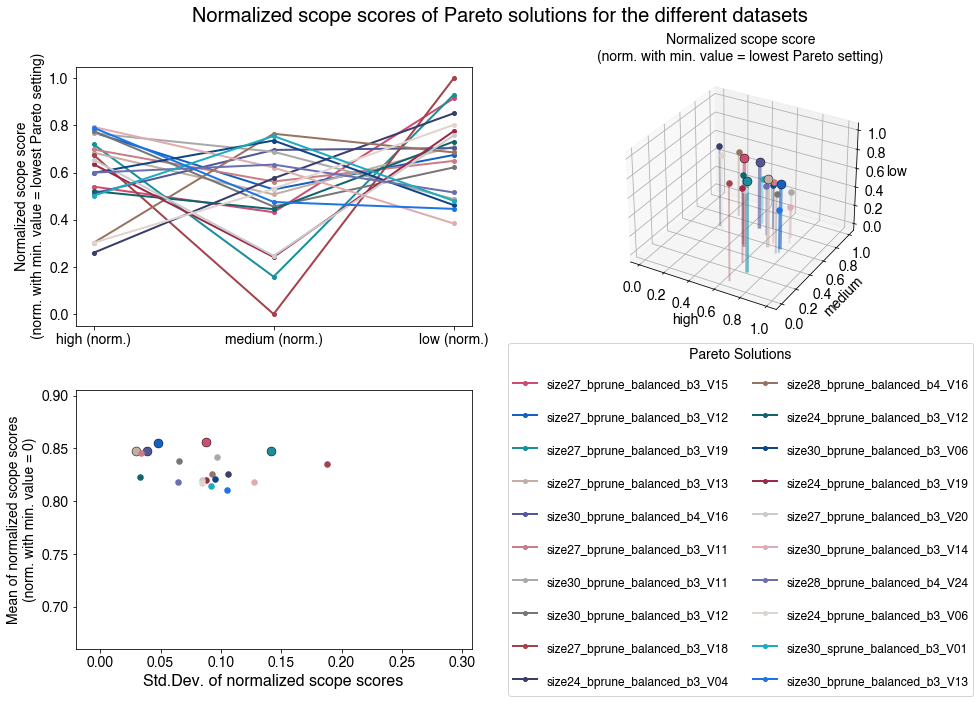

Overview Pareto solutions (sorted by the mean of the normalized scope scores):


high  medium   low  high (norm.)  \
size27_bprune_balanced_b3_V15  0.68    0.30  0.38          0.82   
size27_bprune_balanced_b3_V12  0.76    0.31  0.33          0.91   
size27_bprune_balanced_b3_V19  0.74    0.26  0.39          0.89   
size27_bprune_balanced_b3_V13  0.73    0.31  0.34          0.88   
size30_bprune_balanced_b4_V16  0.67    0.34  0.34          0.81   
size27_bprune_balanced_b3_V11  0.73    0.32  0.33          0.88   
size30_bprune_balanced_b3_V11  0.76    0.34  0.29          0.91   
size30_bprune_balanced_b3_V12  0.76    0.30  0.32          0.91   
size27_bprune_balanced_b3_V18  0.73    0.24  0.40          0.87   
size24_bprune_balanced_b3_V04  0.59    0.32  0.37          0.71   
size28_bprune_balanced_b4_V16  0.61    0.35  0.34          0.73   
size24_bprune_balanced_b3_V12  0.68    0.30  0.35          0.81   
size30_bprune_balanced_b3_V06  0.70    0.34  0.29          0.84   
size24_bprune_balanced_b3_V19  0.71    0.27  0.35          0.86   
size27_bprune_balanced_b3_V20  0.72    0.27  0.35          0.87   
size30_bprune_balanced_b3_V14  0.77    0.33  0.27          0.92   
size28_bprune_balanced_b4_V24  0.70    0.33  0.30          0.84   
size24_bprune_balanced_b3_V06  0.61    0.31  0.36          0.73   
size30_sprune_balanced_b3_V01  0.67    0.35  0.29          0.81   
size30_bprune_balanced_b3_V13  0.76    0.31  0.28          0.92   
size30_bprune_balanced_b3_V02  0.71    0.36  0.26          0.85   
size28_sprune_balanced_b4_V04  0.62    0.34  0.31          0.75   
size30_sprune_balanced_b3_V02  0.74    0.34  0.26          0.89   
size30_bprune_balanced_b3_V04  0.68    0.35  0.28          0.82   
size24_bprune_balanced_b3_V05  0.62    0.31  0.34          0.75   
size30_bprune_balanced_b4_V25  0.81    0.30  0.25          0.97   
size30_bprune_balanced_b3_V19  0.77    0.24  0.33          0.92   
size30_bprune_balanced_b3_V07  0.78    0.32  0.24          0.93   
size30_bprune_balanced_b4_V10  0.68    0.36  0.24          0.81   
size28_bprune_balanced_b4_V10  0.63    0.37  0.24          0.75   
size30_bprune_balanced_b4_V05  0.62    0.36  0.24          0.74   
size24_bprune_balanced_b4_V10  0.51    0.36  0.29          0.61   
size24_bprune_balanced_b4_V11  0.53    0.35  0.29          0.63   
size30_sprune_balanced_b4_V02  0.67    0.37  0.19          0.81   
size28_sprune_balanced_b4_V10  0.81    0.26  0.23          0.98   
size24_sprune_balanced_b4_V02  0.52    0.35  0.27          0.62   
size24_bprune_balanced_b4_V14  0.53    0.35  0.26          0.64   
size24_bprune_balanced_b4_V13  0.52    0.36  0.26          0.62   
size30_sprune_balanced_b4_V08  0.83    0.24  0.22          1.00   
size30_bprune_balanced_b4_V00  0.51    0.38  0.22          0.61   
size30_sprune_balanced_b4_V10  0.82    0.26  0.19          0.98   

                               medium (norm.)  low (norm.)  Mean norm.  \
size27_bprune_balanced_b3_V15            0.79         0.96        0.86   
size27_bprune_balanced_b3_V12            0.83         0.83        0.86   
size27_bprune_balanced_b3_V19            0.69         0.96        0.85   
size27_bprune_balanced_b3_V13            0.82         0.85        0.85   
size30_bprune_balanced_b4_V16            0.89         0.84        0.85   
size27_bprune_balanced_b3_V11            0.84         0.82        0.85   
size30_bprune_balanced_b3_V11            0.89         0.73        0.84   
size30_bprune_balanced_b3_V12            0.80         0.80        0.84   
size27_bprune_balanced_b3_V18            0.63         1.00        0.83   
size24_bprune_balanced_b3_V04            0.84         0.92        0.83   
size28_bprune_balanced_b4_V16            0.91         0.83        0.83   
size24_bprune_balanced_b3_V12            0.80         0.86        0.82   
size30_bprune_balanced_b3_V06            0.90         0.72        0.82   
size24_bprune_balanced_b3_V19            0.72         0.88        0.82   
size27_bprune_balanced_b3_V20            0.72         0.87        0.82   
size30_bprune_balanced_b3_V14   

In [21]:
# only displaying the top 20 results for visibility
print("Visualization of the top 20 Pareto solutions by mean normalized scope score.")
plot_pareto(pareto_settings,pareto_scaled,list(range(20)),[0,1,2,3,4])
df_display_results = get_pareto_table([],[],"Preferred")
print("Overview Pareto solutions (sorted by the mean of the normalized scope scores):")
df_display_results.drop(columns=["Preferred"])

Visualization of the top 5 Pareto solutions by mean normalized scope score.


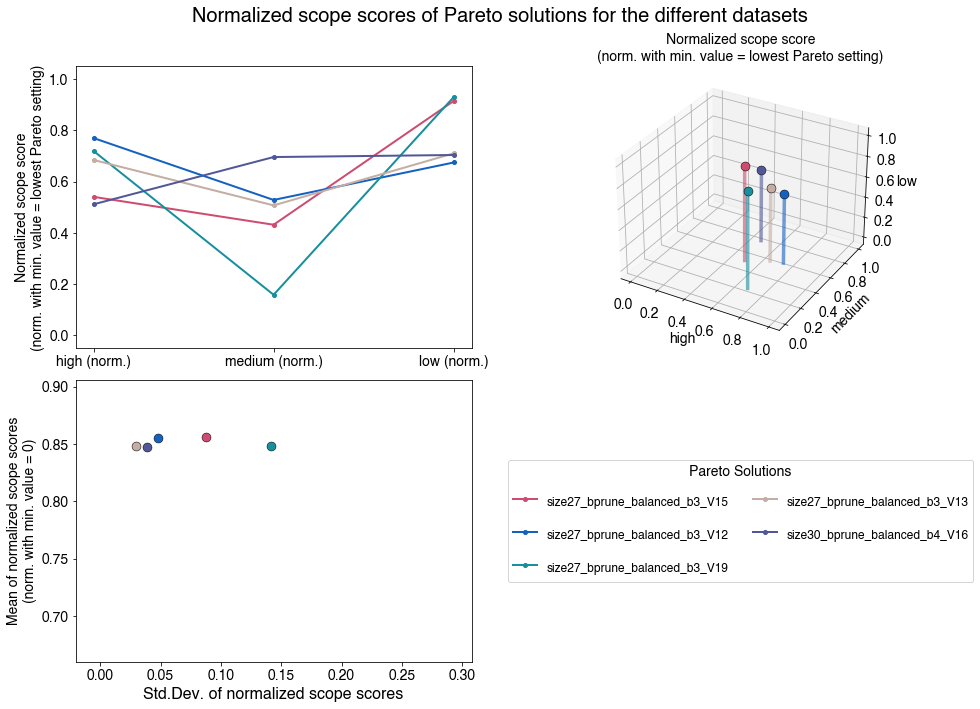

Overview Pareto solutions (sorted by the mean of the normalized scope scores):


high  medium   low  high (norm.)  \
size27_bprune_balanced_b3_V15  0.68    0.30  0.38          0.82   
size27_bprune_balanced_b3_V12  0.76    0.31  0.33          0.91   
size27_bprune_balanced_b3_V19  0.74    0.26  0.39          0.89   
size27_bprune_balanced_b3_V13  0.73    0.31  0.34          0.88   
size30_bprune_balanced_b4_V16  0.67    0.34  0.34          0.81   

                               medium (norm.)  low (norm.)  Mean norm.  \
size27_bprune_balanced_b3_V15            0.79         0.96        0.86   
size27_bprune_balanced_b3_V12            0.83         0.83        0.86   
size27_bprune_balanced_b3_V19            0.69         0.96        0.85   
size27_bprune_balanced_b3_V13            0.82         0.85        0.85   
size30_bprune_balanced_b4_V16            0.89         0.84        0.85   

                               Std.Dev. norm. Plot color  
size27_bprune_balanced_b3_V15            0.09        red  
size27_bprune_balanced_b3_V12            0.05       blue  
size27_bprune_balanced_b3_V19            0.14      green  
size27_bprune_balanced_b3_V13            0.03      ocher  
size30_bprune_balanced_b4_V16            0.04     purple

In [22]:
# only displaying the top 20 results for visibility
print("Visualization of the top 5 Pareto solutions by mean normalized scope score.")
plot_pareto(pareto_settings,pareto_scaled,list(range(5)),[0,1,2, 3,4])
df_display_results = get_pareto_table([],[],"Preferred")
print("Overview Pareto solutions (sorted by the mean of the normalized scope scores):")
df_display_results.drop(columns=["Preferred"]).head(5)

We selected the conditions size27_balanced_b3_V13 because they have almost the same performance as the values above it, but lower std and better performance for the low-performance dataset which likely most closely mirrows most real-life datasets.

Let's print an example scope that is close to the average performance

In [23]:
# find the scope that gives the most average scope score

_, dict_dfs_raw_data = Benchmark.get_metric_overview(bounds=get_bounds("medium"),budget=30,type_results="scope", 
                            name_results=f"./Results_Data/Cond_Screen/screen_bprune/tuning/30balanced_medium/30balanced_b3/")

# dict_dfs_raw_data contains the a dict for each batch-pruning 
# combination which in turn contains a dict of the raw data for the differnt random seeds
# --> restrict to the relevant data (batch size 2 and no Vendi pruning)
dfs_raw_data = dict_dfs_raw_data["b3_V13"]

# restrict to 27 samples (== 9 rounds à 3 samples)
dfs_raw_data = {seed: df.iloc[:9,:] for seed,df in dfs_raw_data.items()}

# collect the scope scores
# NOTE: the indices are the (zero-indexed) rounds --> round 8 is the full scope of 27 samples
score_dict = {seed: df.loc[8,"scope"] for seed,df in dfs_raw_data.items()}
av_score = np.mean(np.array(list(score_dict.values())))

# calculate the absolute difference to the average score
score_diff = {seed: abs(score-av_score) for seed,score in score_dict.items()}

# get the seed that is closest to the average
av_seed = min(score_diff,key=score_diff.get)
print(f"Seed that has the performance closest to the average: ", av_seed)

Seed that has the performance closest to the average:  15


Displaying by round of selection and visualizing the cut samples
Scope score: 0.296
Average rate: 1.557
Vendi score: 4.765


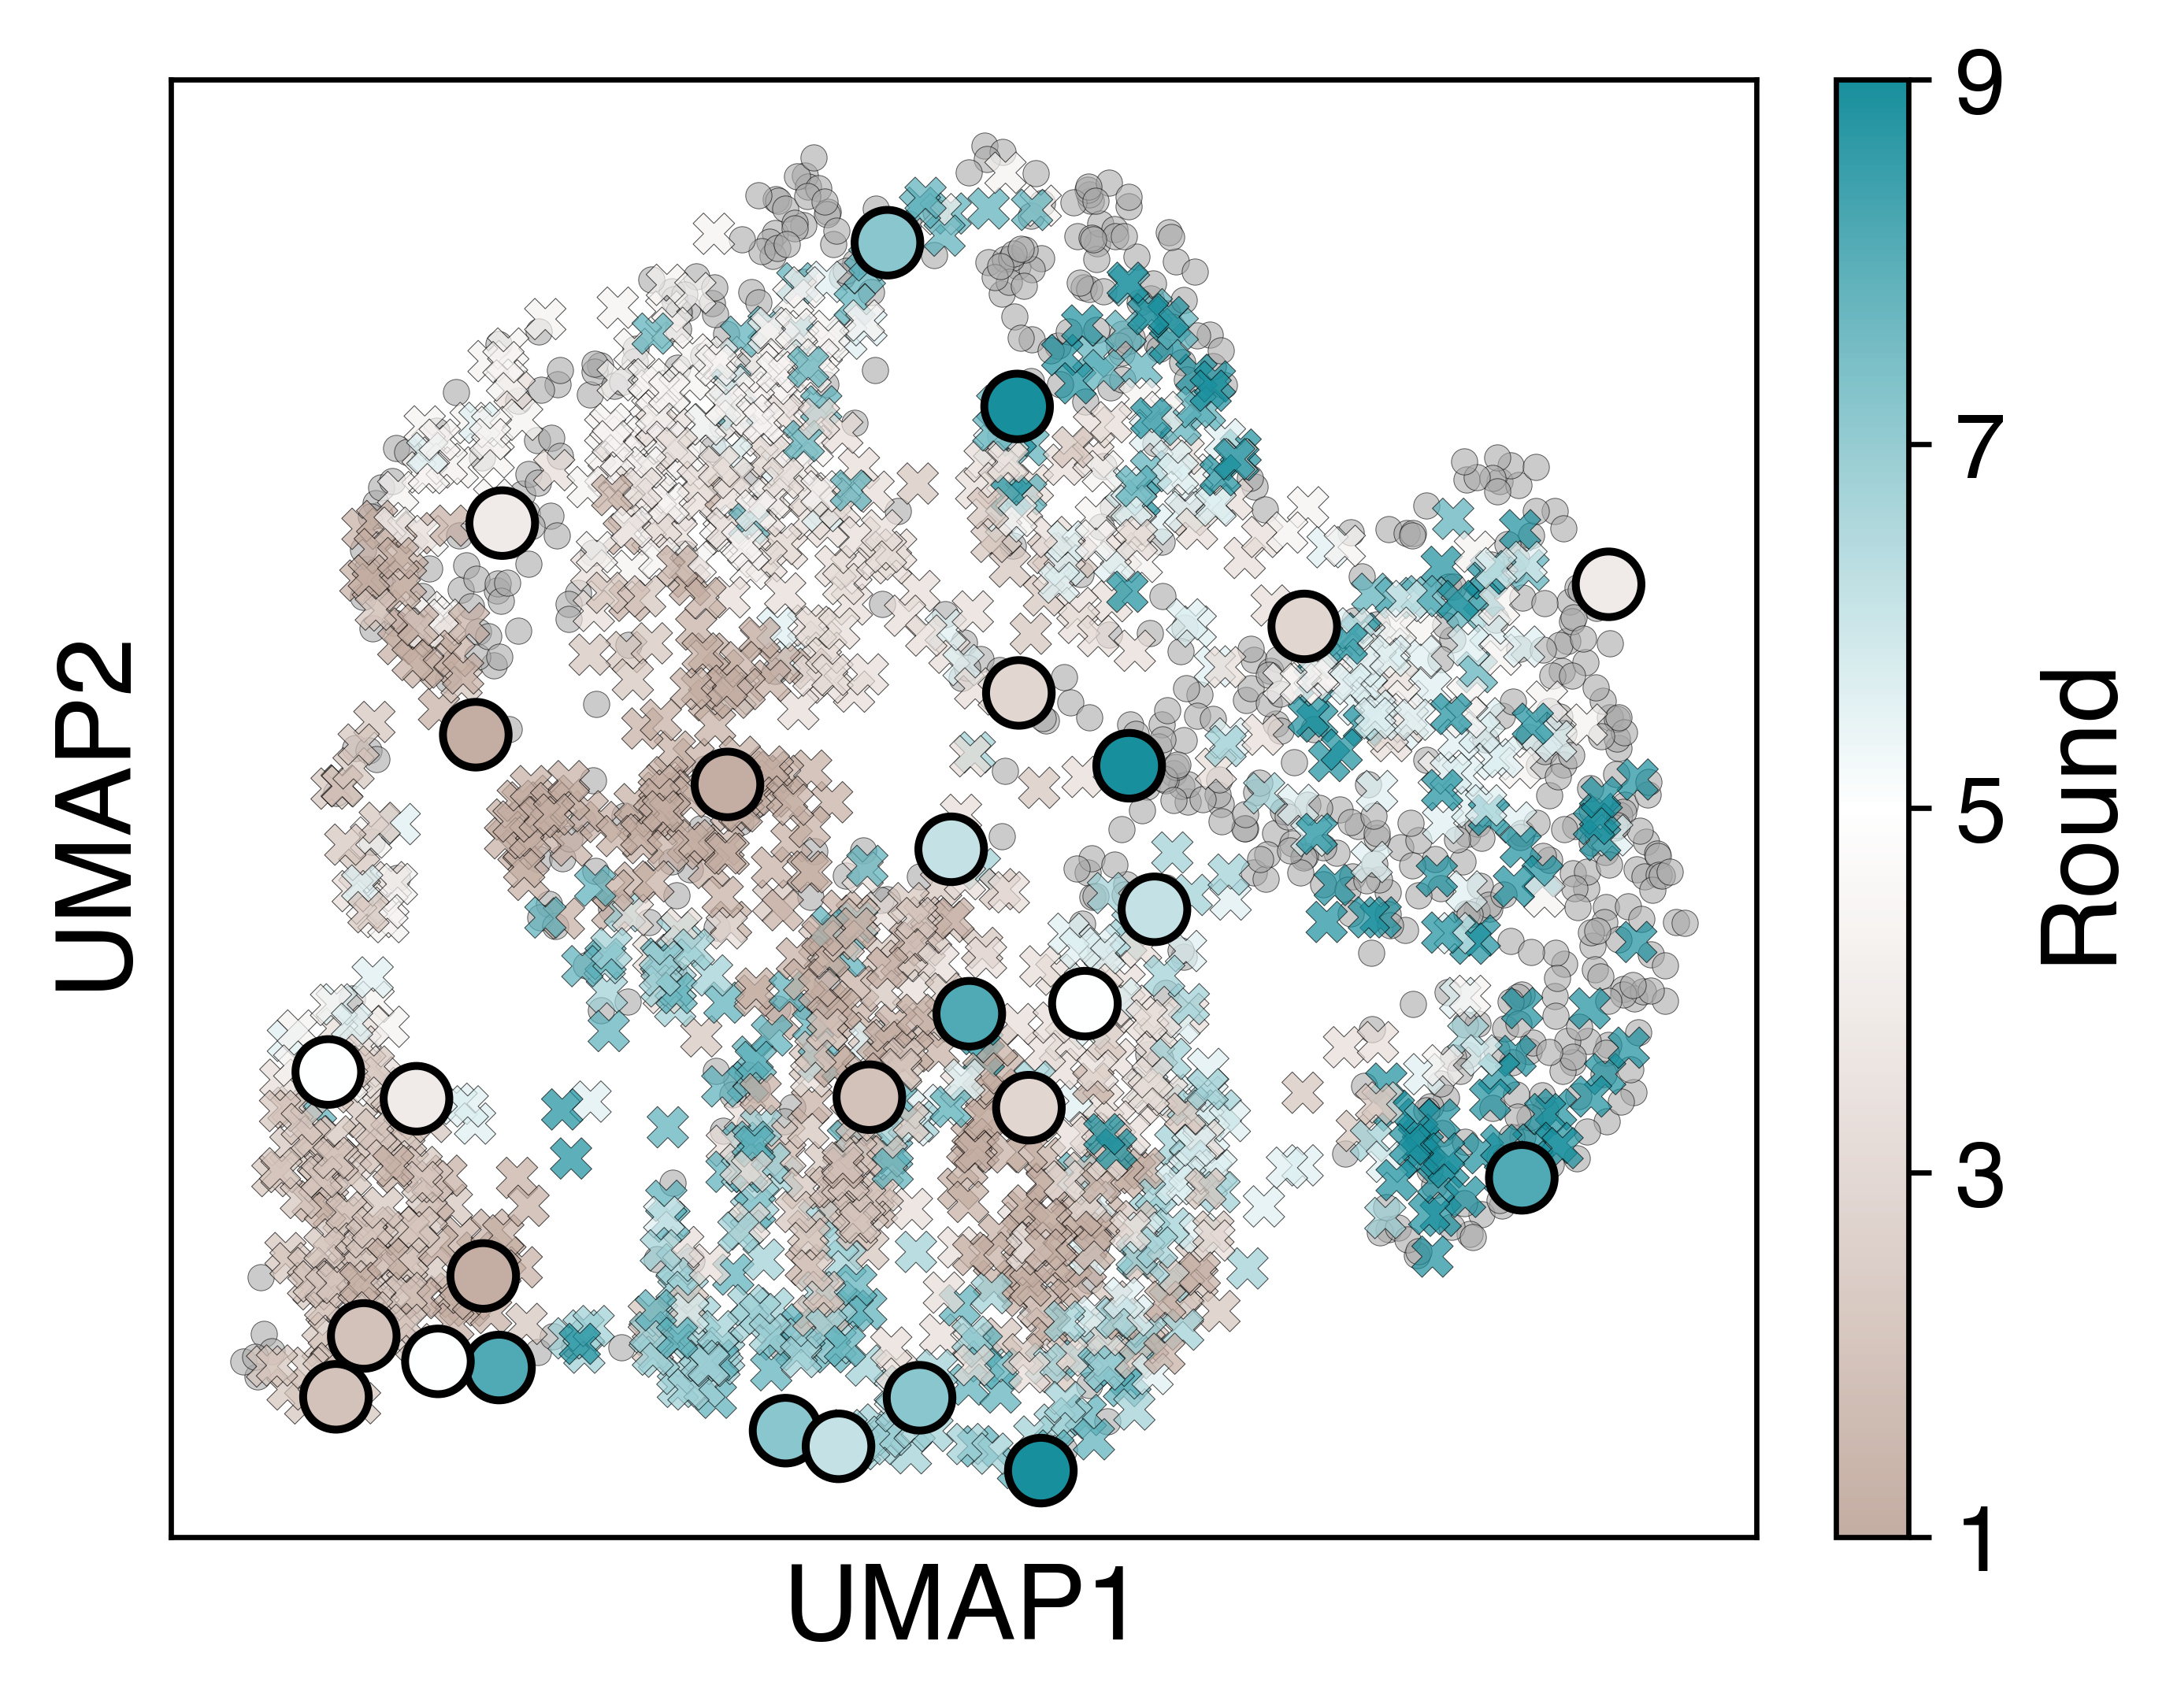

Displaying the performance
Scope score: 0.296
Average rate: 1.557
Vendi score: 4.765


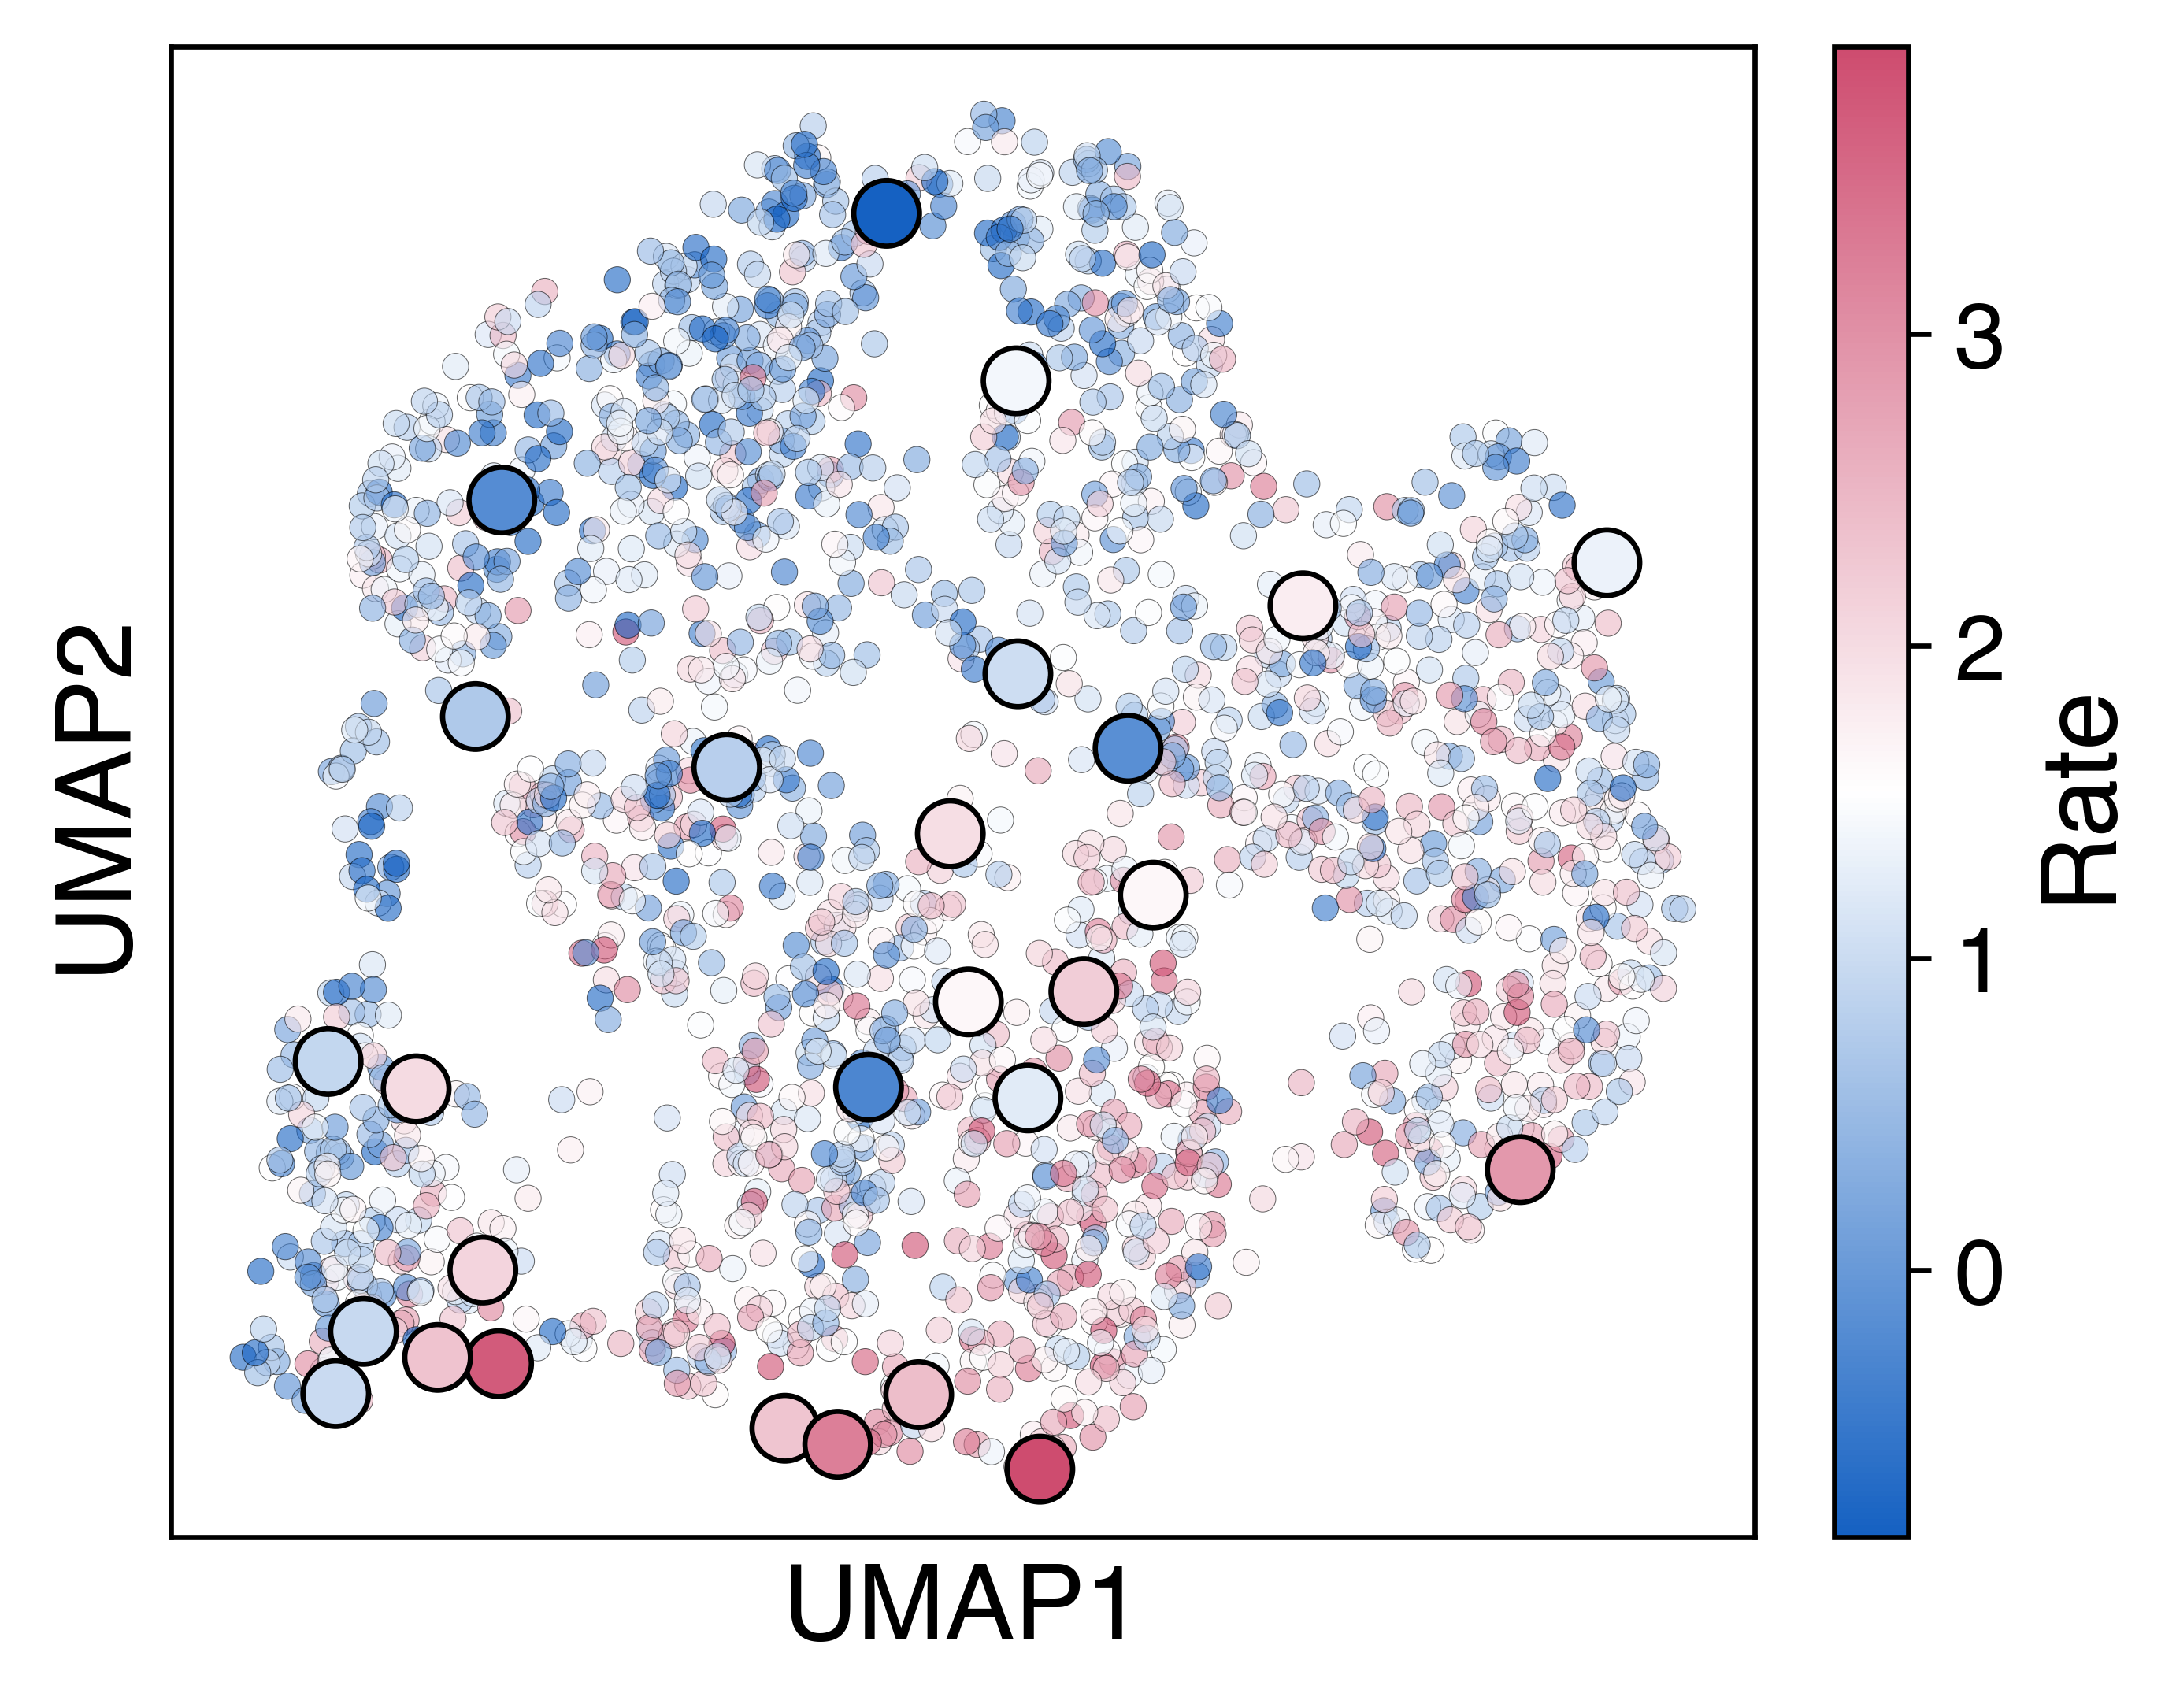

In [24]:
# show the scope for seed 15
for label in [True, False]:
    if label:
        print("Displaying by round of selection and visualizing the cut samples")
    else:
        print("Displaying the performance")
    Benchmark().track_samples(filename_umap="./../0_Data/ArI_UMAP_coords_unprocessed.csv",
                            filename_data=f"30balanced_b3_V13_s{av_seed}.csv",
                            bounds=get_bounds("medium"),
                            filename_labelled=f"./../0_Data/Datasets/Datasets_Hyperpar_Opt/data-medium.csv",
                            name_results="./Results_Data/Cond_Screen/screen_bprune/tuning/30balanced_medium"\
                                "/30balanced_b3/raw_data",
                            rounds_to_display=9,  # scope was run up until 30 samples, but 27 (batch size 3 * 9 rounds) was found to be optimal
                            label_round=False,display_cut_samples=label, figsize = (4.5,3.5), size_scaling = 0.4,
                            hide_axis =True, restrict_samples = f"./../0_Data/Datasets/Datasets_Hyperpar_Opt/data-medium.csv",
                            dpi=600)

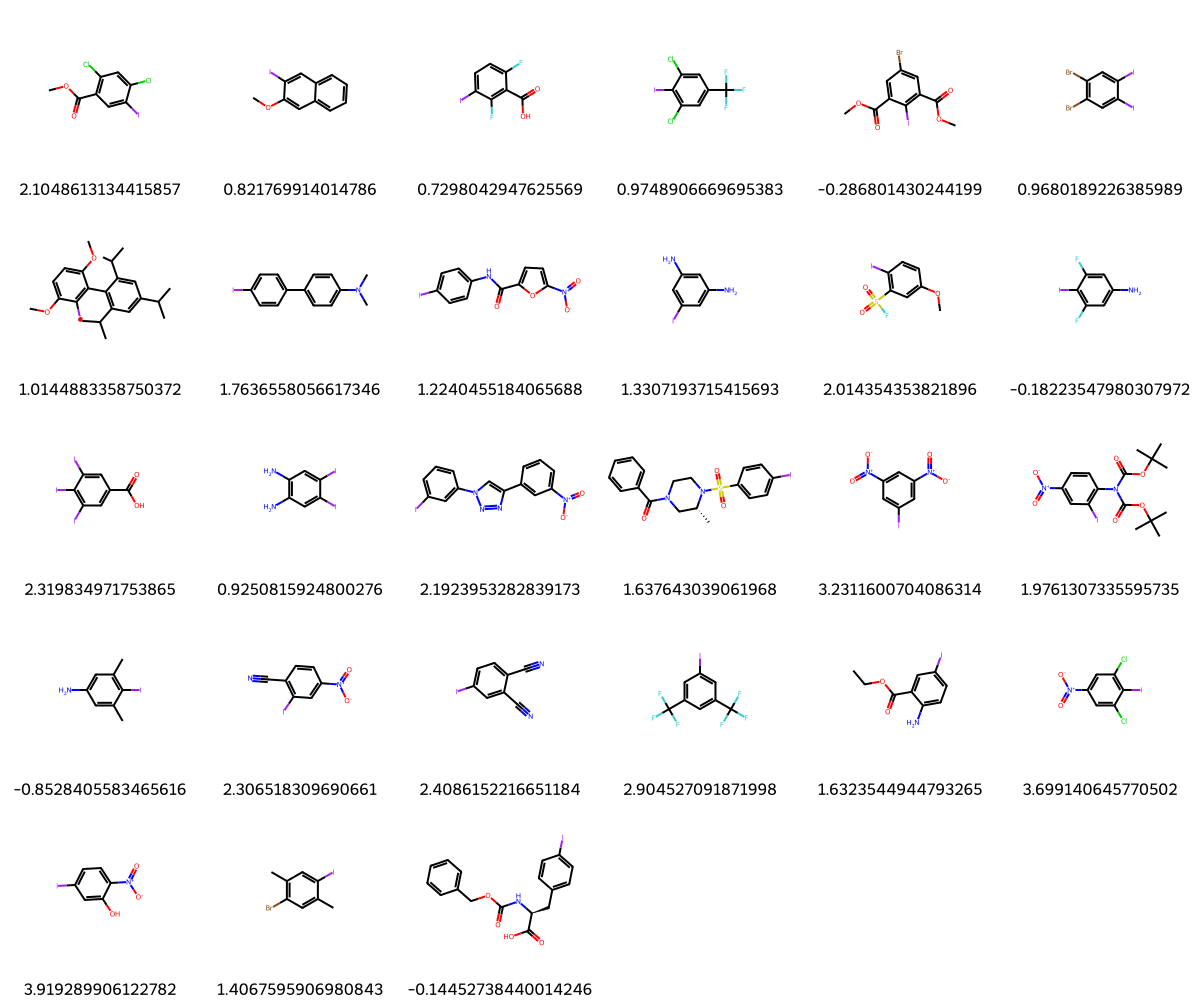

In [25]:
Benchmark().show_scope(filename_data=f"30balanced_b3_V13_s15.csv",
                        name_results=f"./Results_Data/Cond_Screen/screen_bprune/tuning/30balanced_medium/30balanced_b3/raw_data",
                        by_round=False,rounds_to_display=9)

The selected samples contain a variety of functional groups. Please note that the dataset is strongly biased towards highly hindered and electron-poor structures.

Simulation of a human-selected scope (greedy; 5% pruning) for comparison

Scope score: 0.119
Average rate: 1.740
Vendi score: 2.874


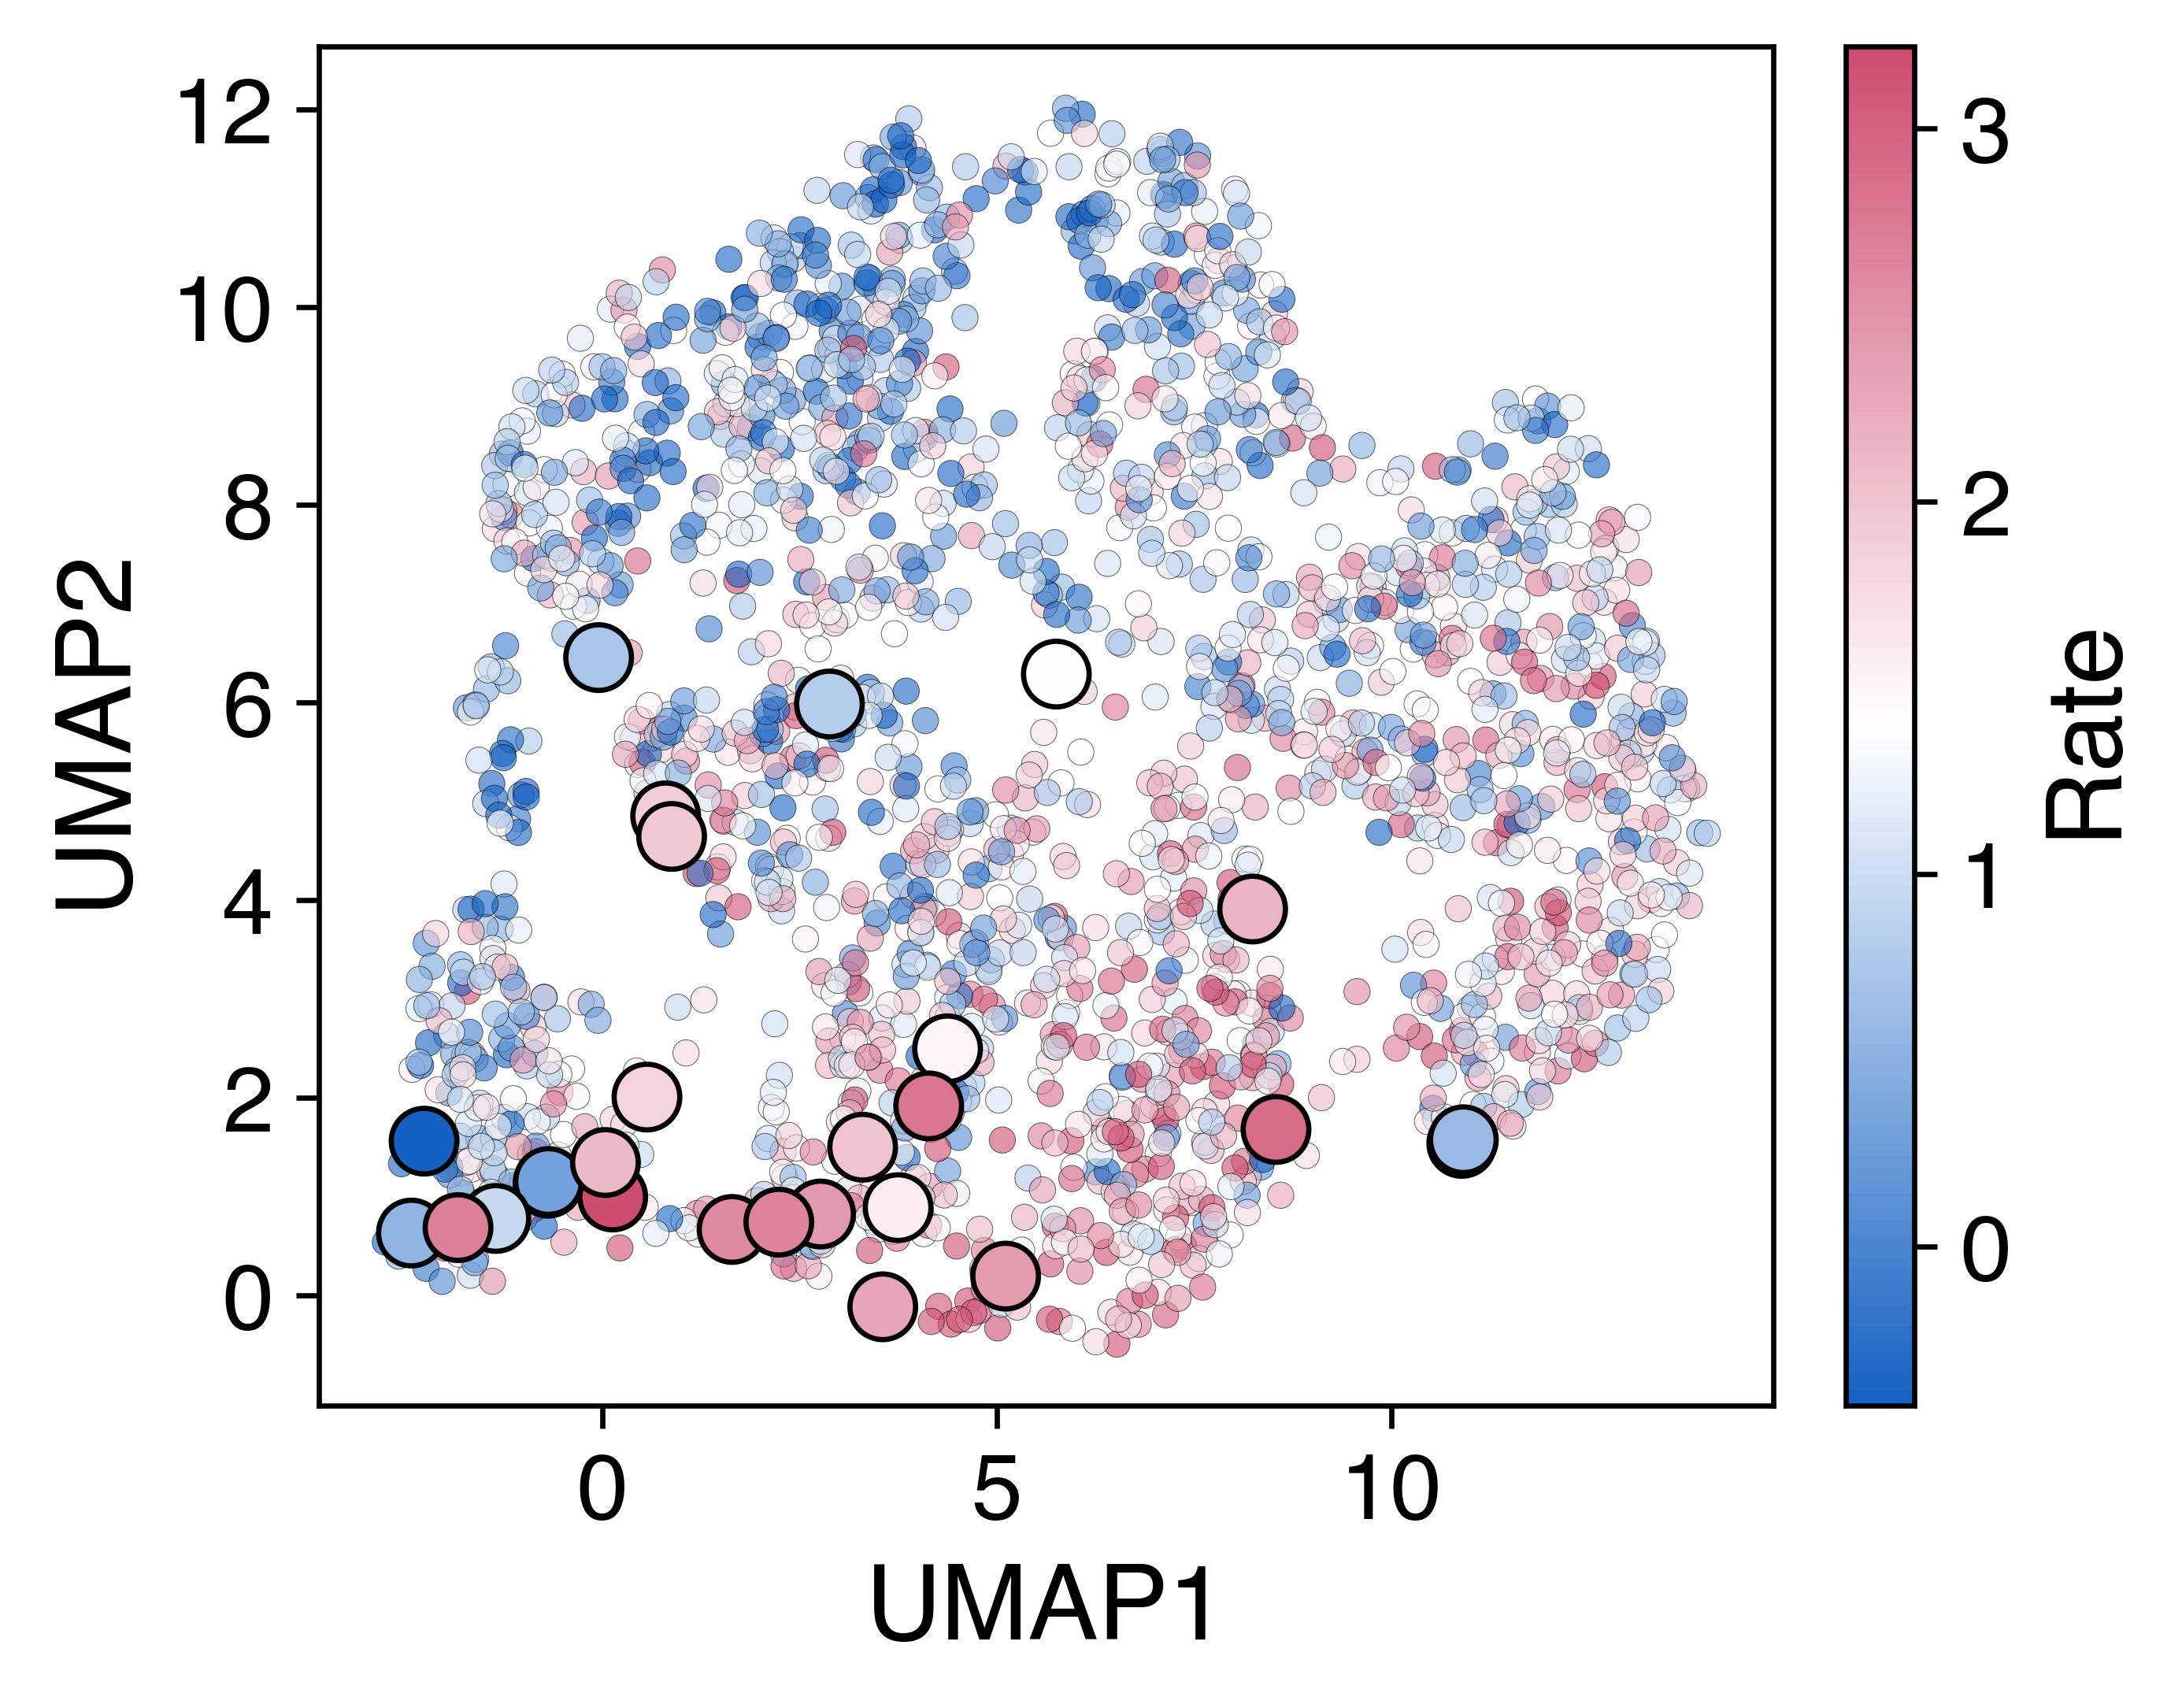

In [26]:
    Benchmark().track_samples(filename_umap="./../0_Data/ArI_UMAP_coords_unprocessed.csv",
                            filename_data=f"30greedy_b3_V5_s15.csv",
                            bounds=get_bounds("medium"),
                            filename_labelled=f"./../0_Data/Datasets/Datasets_Hyperpar_Opt/data-medium.csv",
                            name_results="./Results_Data/Cond_Screen/screen_bprune/30greedy_medium/30greedy_b3/raw_data",
                            rounds_to_display=9,  # scope was run up until 30 samples, but 27 (batch size 3 * 9 rounds) was found to be optimal
                            label_round=False,display_cut_samples=label, figsize = (4.5,3.5), size_scaling = 0.4,
                            restrict_samples = f"./../0_Data/Datasets/Datasets_Hyperpar_Opt/data-medium.csv",dpi=600)